In [1]:
import pybamm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import dfols
import signal
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq, fftshift
from scipy.signal import savgol_filter
from scipy.signal import find_peaks
from scipy import interpolate
from stopit import threading_timeoutable as timeoutable
import os, sys
sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath("__file__"))))
from stopit import threading_timeoutable as timeoutable
from batfuns import *
plt.rcParams = set_rc_params(plt.rcParams)
eSOH_DIR = "/Users/hamid/piibamm/PyBaMM/GM2022/data/esoh_R/"
oCV_DIR = "/Users/hamid/piibamm/PyBaMM/UMBLFeb2022/data/ocv/"
fig_DIR = "../figures/figures_fit/"
res_DIR = "../data/results_fit/"
# %matplotlib widget

In [2]:
parameter_values = pybamm.ParameterValues(chemistry=pybamm.parameter_sets.Andrew2022)

parameter_values.update(
    {
        # mechanical properties
        "Positive electrode Poisson's ratio": 0.3,
        "Positive electrode Young's modulus [Pa]": 375e9,
        "Positive electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Positive electrode partial molar volume [m3.mol-1]": -7.28e-7,
        "Positive electrode volume change": nmc_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Positive electrode LAM constant exponential term": 2,
        "Positive electrode critical stress [Pa]": 375e6,
        # mechanical properties
        "Negative electrode Poisson's ratio": 0.2,
        "Negative electrode Young's modulus [Pa]": 15e9,
        "Negative electrode reference concentration for free of deformation [mol.m-3]": 0,
        "Negative electrode partial molar volume [m3.mol-1]": 3.1e-6,
        "Negative electrode volume change": graphite_volume_change_mohtat,
        # Loss of active materials (LAM) model
        "Negative electrode critical stress [Pa]": 60e6,
        # Other
        "Cell thermal expansion coefficient [m.K-1]": 1.48E-6,
        "Lower voltage cut-off [V]": 2.7,
        
   
        # Initializing Particle Concentration
        # "Initial concentration in negative electrode [mol.m-3]": x100*parameter_values["Maximum concentration in negative electrode [mol.m-3]"],
        # "Initial concentration in positive electrode [mol.m-3]": y100*parameter_values["Maximum concentration in positive electrode [mol.m-3]"]
    },
    check_already_exists=False,
)

In [3]:
parameter_values.search("diffusion")

Negative electrode diffusion coefficient [m2.s-1]	8e-14
Positive electrode diffusion coefficient [m2.s-1]	8e-15


In [4]:
spm = pybamm.lithium_ion.SPM(
    {
        "SEI": "ec reaction limited",
        # "loss of active material": ("stress-driven","none"),
        "loss of active material": "stress-driven",
        # "stress-induced diffusion": "true",
        "lithium plating": "irreversible",
#         "calculate discharge energy":"true"
    }
)

In [5]:
# spm.print_parameter_info()
param=spm.param
parameter_values.update(
    {
    "Electrode width [m]":0.135,
    "Nominal cell capacity [A.h]":3.5,
    "Maximum concentration in negative electrode [mol.m-3]":27200,
    "Maximum concentration in positive electrode [mol.m-3]":33700,
    "Positive electrode thickness [m]":5.565e-05,
    "Negative electrode thickness [m]": 5.5605e-05,
    # "Electrode width [m]" : 0.11,      
    "Negative particle radius [m]":13.5e-06,
    "Positive particle radius [m]":2.1e-06,
     "Positive electrode diffusion coefficient [m2.s-1]":8e-15/2,    
        
        
        
        
        
    }
)
cell = 41

In [6]:
cell_no,dfe,dfe_0,dfo_0,N,N_0 = load_data(cell,eSOH_DIR,oCV_DIR)
eps_n_data,eps_p_data,c_rate_c,c_rate_d,dis_set,Temp,SOC_0 = init_exp(cell_no,dfe,spm,parameter_values)
# Temp
# cell_no,dfe,N,dfo_0 = load_data_calendar(cell,eSOH_DIR,oCV_DIR)
# eps_n_data,eps_p_data,SOC_0,Temp = init_exp_calendar(cell_no,dfe,param,parameter_values)
Temp

25

In [7]:
#experimets
# pybamm.set_logging_level("WARNING")
pybamm.set_logging_level("NOTICE")
Half_Creeted_Drive = pd.read_csv("/Users/hamid/Drive Cycle/Half_hour_creeted_3p5Ah.csv", comment="#", header=None).to_numpy()

experiment33 = pybamm.Experiment( #Created_ DRC-DRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours",
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 1.5 hours",  
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Discharge at C/4 for 1 hours",  
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 2.1 hours",  
         "Rest for 20 minutes",     
        )

    ]*1000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="70% capacity",
#     cccv_handling="ode",
)

experiment34 = pybamm.Experiment( #Creeted-RCRC
    [
        ("Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", 
         "Rest for 5 minutes",
         "Charge at C/4 until 4.2V",
         "Hold at 4.2V for 2.6 hours",  
         "Rest for 20 minutes", 
         # Home
         "Run Half_Creeted_Drive (A) for 0.5 hours",
         "Rest for 5 minutes",
         "Rest for 1 hours", 
         "Rest for 5 minutes",
         "Charge at C/8 until 4.2V",
          "Hold at 4.2V for 3.9 hours",  
         "Rest for 20 minutes",     
        )

    ]*3000,
    drive_cycles={"Half_Creeted_Drive": Half_Creeted_Drive},
    termination="70% capacity",
#     cccv_handling="ode",
)





In [8]:
K_SEI_list=[4.20e-16  , 4.35e-16 , 2.76e-16]
D_SEI_list=[6.66e-19  , 3.69e-19 , 1.75e-19]
k_pl_list=[4.54e-10   , 4.64e-10 , 5.48e-10]
k_diss_list=[0        , 6.24e-04 ,     0   ]
b_LAM_p_list=[10.06e-8, 7.65e-08 ,  3.43e-7]
b_LAM_n_list=[8.73e-8 , 8.76e-08 ,  1.47e-7]
Ea_SEI_list=[6026     , 5997.629 ,   0.    ]
# March17(no diss)    ,March23(dis), July8
list_num=2

# parameter_values = get_parameter_values()
parameter_values.update(
    {
        "Negative electrode active material volume fraction": eps_n_data,
        "Positive electrode active material volume fraction": eps_p_data,
        "Initial temperature [K]": 273.15+Temp,
        "Ambient temperature [K]": 273.15+Temp,
        "Positive electrode LAM constant proportional term [s-1]": b_LAM_p_list[list_num], #10.0638e-08, #8.3747149e-08,#1.27152e-07
        "Negative electrode LAM constant proportional term [s-1]":b_LAM_n_list[list_num],#8.7257e-08, #9.078886e-08,#1.27272e-06
        "Positive electrode LAM constant exponential term": 1.02,
        "Negative electrode LAM constant exponential term": 1.02,
        "SEI kinetic rate constant [m.s-1]":K_SEI_list[list_num],# 4.1964e-16,# 4.17385539e-16, #4.60788219e-16, 1.08494281e-16 , 
        "EC diffusivity [m2.s-1]": D_SEI_list[list_num], #6.6582e-19, #1.79830186e-18, #4.56607447e-19,8.30909086e-19,
        "SEI growth activation energy [J.mol-1]":Ea_SEI_list[list_num],#6.02602e+03, # 6.18700763e+03, #1.87422275e+04,1.58777981e+04,
        "Initial inner SEI thickness [m]": 0e-09,
        "Initial outer SEI thickness [m]": 5e-09,
        "SEI resistivity [Ohm.m]":  1.3e3, #30000.0,# 1.3e06,
        "Lithium plating kinetic rate constant [m.s-1]":k_pl_list[list_num],#4.543e-10, # 4.50936e-10
        
        
        
        #Cathode disolution
        "Positive electrode dissolution exchange current density": k_diss_list[list_num],
        "Negative electrode dissolution exchange current density": 0,
        
        "Positive electrode dissolution nickel SEI coefficient": 0,
        "Negative electrode dissolution nickel SEI coefficient": 0.0,
        
        "Positive electrode dissolution nickel intercalation coefficient": 0,
        "Negative electrode dissolution nickel intercalation coefficient": 0.0,
        
    },
    check_already_exists=False,
)

In [9]:
pybamm.set_logging_level("NOTICE")

sim_long33 = pybamm.Simulation(spm, experiment=experiment33, parameter_values=parameter_values, 
                            solver=pybamm.CasadiSolver("safe",
                            rtol=1e-6, 
                            atol=1e-6,
                            dt_max=10,
                                                      ))
sol_long33 = sim_long33.solve(initial_soc=1, save_at_cycles=1  )


# sim_long34 = pybamm.Simulation(spm, experiment=experiment34, parameter_values=parameter_values, 
#                             solver=pybamm.CasadiSolver("safe",
#                             rtol=1e-6, 
#                             atol=1e-6,
#                             dt_max=10,
#                                                       ))
# sol_long34 = sim_long34.solve(initial_soc=1, save_at_cycles=1  )


2023-07-10 15:11:36.362 - [NOTICE] callbacks.on_cycle_start(174): Cycle 1/1000 (14.608 ms elapsed) --------------------
2023-07-10 15:11:36.362 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
CasADi - 2023-07-10 15:11:36 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:521]
2023-07-10 15:11:36.876 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:11:36.936 - [NOTICE] callbacks.on_step_start(182): Cycle 1/1000, step 3/14:

2023-07-10 15:11:46.462 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:11:46.473 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:11:46.541 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:11:46.550 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:11:46.650 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:11:46.871 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:11:46.894 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:11:47.305 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:11:47.317 - [NOTICE] callbacks.on_step_start(182): Cycle 5/1000, st

2023-07-10 15:11:56.713 - [NOTICE] callbacks.on_step_start(182): Cycle 9/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:11:56.724 - [NOTICE] callbacks.on_step_start(182): Cycle 9/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:11:56.791 - [NOTICE] callbacks.on_step_start(182): Cycle 9/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:11:56.802 - [NOTICE] callbacks.on_step_start(182): Cycle 9/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:11:56.996 - [NOTICE] callbacks.on_step_start(182): Cycle 9/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:11:57.315 - [NOTICE] callbacks.on_step_start(182): Cycle 9/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:11:57.648 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.527 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:11:57.648 - [NOTICE] callbacks.on_cycle_start(174): Cycle 10/1000 (21.301 s elapsed) --------------------
2023-07-10 15:11:57.649 - [NOTICE] callbacks.on_step_start(182

2023-07-10 15:12:06.593 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.521 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:12:06.593 - [NOTICE] callbacks.on_cycle_start(174): Cycle 14/1000 (30.246 s elapsed) --------------------
2023-07-10 15:12:06.594 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:12:07.013 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:12:07.022 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:12:07.092 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:12:07.103 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:12:07.211 - [NOTICE] callbacks.on_step_start(182): Cycle 14/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:12:07.438 - [NOTICE] callb

2023-07-10 15:12:16.470 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:12:16.580 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:12:16.805 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:12:16.827 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:12:17.265 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:12:17.275 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:12:17.348 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:12:17.359 - [NOTICE] callbacks.on_step_start(182): Cycle 18/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:12:17.574 - [NOTICE] callbacks.on_step_start(182):

2023-07-10 15:12:26.520 - [NOTICE] callbacks.on_step_start(182): Cycle 22/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:12:26.531 - [NOTICE] callbacks.on_step_start(182): Cycle 22/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:12:26.723 - [NOTICE] callbacks.on_step_start(182): Cycle 22/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:12:27.036 - [NOTICE] callbacks.on_step_start(182): Cycle 22/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:12:27.352 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.508 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:12:27.353 - [NOTICE] callbacks.on_cycle_start(174): Cycle 23/1000 (51.006 s elapsed) --------------------
2023-07-10 15:12:27.353 - [NOTICE] callbacks.on_step_start(182): Cycle 23/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:12:27.769 - [NOTICE] callbacks.on_step_start(182): Cycle 23/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:12:27.778 - [NOTICE] callbacks.

2023-07-10 15:12:36.414 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:12:36.879 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:12:36.888 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:12:36.973 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:12:36.984 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:12:37.110 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:12:37.360 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:12:37.383 - [NOTICE] callbacks.on_step_start(182): Cycle 27/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:12:37.812 - [NOTICE] callbacks.on_ste

2023-07-10 15:12:46.647 - [NOTICE] callbacks.on_step_start(182): Cycle 31/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:12:46.868 - [NOTICE] callbacks.on_step_start(182): Cycle 31/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:12:46.895 - [NOTICE] callbacks.on_step_start(182): Cycle 31/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:12:47.338 - [NOTICE] callbacks.on_step_start(182): Cycle 31/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:12:47.351 - [NOTICE] callbacks.on_step_start(182): Cycle 31/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:12:47.425 - [NOTICE] callbacks.on_step_start(182): Cycle 31/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:12:47.438 - [NOTICE] callbacks.on_step_start(182): Cycle 31/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:12:47.653 - [NOTICE] callbacks.on_step_start(182): Cycle 31/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:12:47.978 - [NOTICE] callbacks.on_step_start(18

2023-07-10 15:12:56.896 - [NOTICE] callbacks.on_step_start(182): Cycle 35/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:12:56.907 - [NOTICE] callbacks.on_step_start(182): Cycle 35/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:12:57.118 - [NOTICE] callbacks.on_step_start(182): Cycle 35/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:12:57.436 - [NOTICE] callbacks.on_step_start(182): Cycle 35/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:12:57.784 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.488 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:12:57.784 - [NOTICE] callbacks.on_cycle_start(174): Cycle 36/1000 (1 minute, 21 seconds elapsed) --------------------
2023-07-10 15:12:57.785 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:12:58.197 - [NOTICE] callbacks.on_step_start(182): Cycle 36/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:12:58.206 - [NOTICE

2023-07-10 15:13:07.344 - [NOTICE] callbacks.on_cycle_start(174): Cycle 40/1000 (1 minute, 31 seconds elapsed) --------------------
2023-07-10 15:13:07.349 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:13:07.755 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:13:07.768 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:13:07.830 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:13:07.843 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:13:07.961 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:13:08.200 - [NOTICE] callbacks.on_step_start(182): Cycle 40/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:13:08.223 - [NOTICE] callbacks.on_ste

2023-07-10 15:13:17.111 - [NOTICE] callbacks.on_step_start(182): Cycle 44/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:13:17.218 - [NOTICE] callbacks.on_step_start(182): Cycle 44/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:13:17.456 - [NOTICE] callbacks.on_step_start(182): Cycle 44/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:13:17.478 - [NOTICE] callbacks.on_step_start(182): Cycle 44/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:13:17.885 - [NOTICE] callbacks.on_step_start(182): Cycle 44/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:13:17.897 - [NOTICE] callbacks.on_step_start(182): Cycle 44/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:13:17.968 - [NOTICE] callbacks.on_step_start(182): Cycle 44/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:13:17.978 - [NOTICE] callbacks.on_step_start(182): Cycle 44/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:13:18.173 - [NOTICE] callbacks.on_step_start(182):

2023-07-10 15:13:27.330 - [NOTICE] callbacks.on_step_start(182): Cycle 48/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:13:27.396 - [NOTICE] callbacks.on_step_start(182): Cycle 48/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:13:27.408 - [NOTICE] callbacks.on_step_start(182): Cycle 48/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:13:27.599 - [NOTICE] callbacks.on_step_start(182): Cycle 48/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:13:27.912 - [NOTICE] callbacks.on_step_start(182): Cycle 48/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:13:28.240 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.469 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:13:28.241 - [NOTICE] callbacks.on_cycle_start(174): Cycle 49/1000 (1 minute, 52 seconds elapsed) --------------------
2023-07-10 15:13:28.248 - [NOTICE] callbacks.on_step_start(182): Cycle 49/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:13:28.66

2023-07-10 15:13:37.470 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.463 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:13:37.470 - [NOTICE] callbacks.on_cycle_start(174): Cycle 53/1000 (2 minutes, 1 second elapsed) --------------------
2023-07-10 15:13:37.471 - [NOTICE] callbacks.on_step_start(182): Cycle 53/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:13:37.909 - [NOTICE] callbacks.on_step_start(182): Cycle 53/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:13:37.918 - [NOTICE] callbacks.on_step_start(182): Cycle 53/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:13:37.985 - [NOTICE] callbacks.on_step_start(182): Cycle 53/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:13:37.997 - [NOTICE] callbacks.on_step_start(182): Cycle 53/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:13:38.101 - [NOTICE] callbacks.on_step_start(182): Cycle 53/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:13:38.324 - [NO

2023-07-10 15:13:46.821 - [NOTICE] callbacks.on_step_start(182): Cycle 57/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:13:46.832 - [NOTICE] callbacks.on_step_start(182): Cycle 57/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:13:46.941 - [NOTICE] callbacks.on_step_start(182): Cycle 57/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:13:47.161 - [NOTICE] callbacks.on_step_start(182): Cycle 57/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:13:47.184 - [NOTICE] callbacks.on_step_start(182): Cycle 57/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:13:47.648 - [NOTICE] callbacks.on_step_start(182): Cycle 57/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:13:47.659 - [NOTICE] callbacks.on_step_start(182): Cycle 57/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:13:47.734 - [NOTICE] callbacks.on_step_start(182): Cycle 57/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:13:47.746 - [NOTICE] callbacks.on_step_start(182): Cycle 

2023-07-10 15:13:57.354 - [NOTICE] callbacks.on_step_start(182): Cycle 61/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:13:57.364 - [NOTICE] callbacks.on_step_start(182): Cycle 61/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:13:57.439 - [NOTICE] callbacks.on_step_start(182): Cycle 61/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:13:57.449 - [NOTICE] callbacks.on_step_start(182): Cycle 61/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:13:57.663 - [NOTICE] callbacks.on_step_start(182): Cycle 61/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:13:57.991 - [NOTICE] callbacks.on_step_start(182): Cycle 61/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:13:58.351 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.449 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:13:58.352 - [NOTICE] callbacks.on_cycle_start(174): Cycle 62/1000 (2 minutes, 22 seconds elapsed) --------------------
2023-07-10 15:13:58.352 - [NOTICE] callback

2023-07-10 15:14:07.072 - [NOTICE] callbacks.on_step_start(182): Cycle 65/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:14:07.431 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.443 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:14:07.432 - [NOTICE] callbacks.on_cycle_start(174): Cycle 66/1000 (2 minutes, 31 seconds elapsed) --------------------
2023-07-10 15:14:07.432 - [NOTICE] callbacks.on_step_start(182): Cycle 66/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:14:07.875 - [NOTICE] callbacks.on_step_start(182): Cycle 66/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:14:07.886 - [NOTICE] callbacks.on_step_start(182): Cycle 66/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:14:07.957 - [NOTICE] callbacks.on_step_start(182): Cycle 66/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:14:07.966 - [NOTICE] callbacks.on_step_start(182): Cycle 66/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:14:08.074 - [NOTICE

2023-07-10 15:14:17.432 - [NOTICE] callbacks.on_step_start(182): Cycle 70/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:14:17.496 - [NOTICE] callbacks.on_step_start(182): Cycle 70/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:14:17.506 - [NOTICE] callbacks.on_step_start(182): Cycle 70/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:14:17.629 - [NOTICE] callbacks.on_step_start(182): Cycle 70/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:14:17.852 - [NOTICE] callbacks.on_step_start(182): Cycle 70/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:14:17.878 - [NOTICE] callbacks.on_step_start(182): Cycle 70/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:14:18.298 - [NOTICE] callbacks.on_step_start(182): Cycle 70/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:14:18.311 - [NOTICE] callbacks.on_step_start(182): Cycle 70/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:14:18.381 - [NOTICE] callbacks.on_step_start(182

2023-07-10 15:14:26.827 - [NOTICE] callbacks.on_step_start(182): Cycle 74/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:14:27.251 - [NOTICE] callbacks.on_step_start(182): Cycle 74/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:14:27.262 - [NOTICE] callbacks.on_step_start(182): Cycle 74/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:14:27.327 - [NOTICE] callbacks.on_step_start(182): Cycle 74/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:14:27.338 - [NOTICE] callbacks.on_step_start(182): Cycle 74/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:14:27.540 - [NOTICE] callbacks.on_step_start(182): Cycle 74/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:14:27.851 - [NOTICE] callbacks.on_step_start(182): Cycle 74/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:14:28.186 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.430 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:14:28.187 - [NOTICE] callbacks

2023-07-10 15:14:36.553 - [NOTICE] callbacks.on_step_start(182): Cycle 78/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:14:36.856 - [NOTICE] callbacks.on_step_start(182): Cycle 78/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:14:37.193 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.424 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:14:37.194 - [NOTICE] callbacks.on_cycle_start(174): Cycle 79/1000 (3 minutes, 1 second elapsed) --------------------
2023-07-10 15:14:37.194 - [NOTICE] callbacks.on_step_start(182): Cycle 79/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:14:37.626 - [NOTICE] callbacks.on_step_start(182): Cycle 79/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:14:37.634 - [NOTICE] callbacks.on_step_start(182): Cycle 79/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:14:37.702 - [NOTICE] callbacks.on_step_start(182): Cycle 79/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:14:37.713 - [NOTIC

2023-07-10 15:14:46.625 - [NOTICE] callbacks.on_step_start(182): Cycle 83/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:14:46.637 - [NOTICE] callbacks.on_step_start(182): Cycle 83/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:14:46.705 - [NOTICE] callbacks.on_step_start(182): Cycle 83/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:14:46.714 - [NOTICE] callbacks.on_step_start(182): Cycle 83/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:14:46.815 - [NOTICE] callbacks.on_step_start(182): Cycle 83/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:14:47.038 - [NOTICE] callbacks.on_step_start(182): Cycle 83/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:14:47.063 - [NOTICE] callbacks.on_step_start(182): Cycle 83/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:14:47.465 - [NOTICE] callbacks.on_step_start(182): Cycle 83/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:14:47.481 - [NOTICE] callbacks.on_step_start(182): Cycle 83

2023-07-10 15:14:56.317 - [NOTICE] callbacks.on_step_start(182): Cycle 87/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:14:56.340 - [NOTICE] callbacks.on_step_start(182): Cycle 87/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:14:56.801 - [NOTICE] callbacks.on_step_start(182): Cycle 87/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:14:56.815 - [NOTICE] callbacks.on_step_start(182): Cycle 87/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:14:56.890 - [NOTICE] callbacks.on_step_start(182): Cycle 87/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:14:56.901 - [NOTICE] callbacks.on_step_start(182): Cycle 87/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:14:57.108 - [NOTICE] callbacks.on_step_start(182): Cycle 87/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:14:57.447 - [NOTICE] callbacks.on_step_start(182): Cycle 87/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:14:57.867 - [NOTICE] callbacks.on_cycle_end(196): Cap

2023-07-10 15:15:07.311 - [NOTICE] callbacks.on_step_start(182): Cycle 91/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:15:07.509 - [NOTICE] callbacks.on_step_start(182): Cycle 91/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:15:07.864 - [NOTICE] callbacks.on_step_start(182): Cycle 91/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:15:08.243 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.405 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:15:08.244 - [NOTICE] callbacks.on_cycle_start(174): Cycle 92/1000 (3 minutes, 32 seconds elapsed) --------------------
2023-07-10 15:15:08.245 - [NOTICE] callbacks.on_step_start(182): Cycle 92/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:15:08.696 - [NOTICE] callbacks.on_step_start(182): Cycle 92/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:15:08.707 - [NOTICE] callbacks.on_step_start(182): Cycle 92/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:15:08.771

2023-07-10 15:15:17.573 - [NOTICE] callbacks.on_step_start(182): Cycle 96/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:15:18.067 - [NOTICE] callbacks.on_step_start(182): Cycle 96/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:15:18.078 - [NOTICE] callbacks.on_step_start(182): Cycle 96/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:15:18.144 - [NOTICE] callbacks.on_step_start(182): Cycle 96/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:15:18.158 - [NOTICE] callbacks.on_step_start(182): Cycle 96/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:15:18.273 - [NOTICE] callbacks.on_step_start(182): Cycle 96/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:15:18.518 - [NOTICE] callbacks.on_step_start(182): Cycle 96/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:15:18.542 - [NOTICE] callbacks.on_step_start(182): Cycle 96/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:15:19.003 - [NOTICE] callbacks.on_ste

2023-07-10 15:15:27.643 - [NOTICE] callbacks.on_step_start(182): Cycle 100/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:15:27.868 - [NOTICE] callbacks.on_step_start(182): Cycle 100/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:15:27.892 - [NOTICE] callbacks.on_step_start(182): Cycle 100/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:15:28.303 - [NOTICE] callbacks.on_step_start(182): Cycle 100/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:15:28.315 - [NOTICE] callbacks.on_step_start(182): Cycle 100/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:15:28.381 - [NOTICE] callbacks.on_step_start(182): Cycle 100/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:15:28.392 - [NOTICE] callbacks.on_step_start(182): Cycle 100/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:15:28.587 - [NOTICE] callbacks.on_step_start(182): Cycle 100/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:15:28.905 - [NOTICE] callbacks.on_step_

2023-07-10 15:15:37.399 - [NOTICE] callbacks.on_step_start(182): Cycle 104/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:15:37.411 - [NOTICE] callbacks.on_step_start(182): Cycle 104/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:15:37.614 - [NOTICE] callbacks.on_step_start(182): Cycle 104/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:15:37.922 - [NOTICE] callbacks.on_step_start(182): Cycle 104/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:15:38.273 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.385 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:15:38.273 - [NOTICE] callbacks.on_cycle_start(174): Cycle 105/1000 (4 minutes, 2 seconds elapsed) --------------------
2023-07-10 15:15:38.274 - [NOTICE] callbacks.on_step_start(182): Cycle 105/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:15:38.728 - [NOTICE] callbacks.on_step_start(182): Cycle 105/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:15:38.738 - 

2023-07-10 15:15:47.295 - [NOTICE] callbacks.on_cycle_start(174): Cycle 109/1000 (4 minutes, 11 seconds elapsed) --------------------
2023-07-10 15:15:47.295 - [NOTICE] callbacks.on_step_start(182): Cycle 109/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:15:47.739 - [NOTICE] callbacks.on_step_start(182): Cycle 109/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:15:47.749 - [NOTICE] callbacks.on_step_start(182): Cycle 109/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:15:47.819 - [NOTICE] callbacks.on_step_start(182): Cycle 109/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:15:47.828 - [NOTICE] callbacks.on_step_start(182): Cycle 109/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:15:47.934 - [NOTICE] callbacks.on_step_start(182): Cycle 109/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:15:48.150 - [NOTICE] callbacks.on_step_start(182): Cycle 109/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:15:48.175 - [NOTICE] callbac

2023-07-10 15:15:57.233 - [NOTICE] callbacks.on_step_start(182): Cycle 113/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:15:57.371 - [NOTICE] callbacks.on_step_start(182): Cycle 113/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:15:57.590 - [NOTICE] callbacks.on_step_start(182): Cycle 113/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:15:57.613 - [NOTICE] callbacks.on_step_start(182): Cycle 113/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:15:58.018 - [NOTICE] callbacks.on_step_start(182): Cycle 113/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:15:58.032 - [NOTICE] callbacks.on_step_start(182): Cycle 113/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:15:58.100 - [NOTICE] callbacks.on_step_start(182): Cycle 113/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:15:58.109 - [NOTICE] callbacks.on_step_start(182): Cycle 113/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:15:58.301 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:16:07.736 - [NOTICE] callbacks.on_step_start(182): Cycle 117/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:16:07.801 - [NOTICE] callbacks.on_step_start(182): Cycle 117/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:16:07.810 - [NOTICE] callbacks.on_step_start(182): Cycle 117/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:16:08.004 - [NOTICE] callbacks.on_step_start(182): Cycle 117/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:16:08.312 - [NOTICE] callbacks.on_step_start(182): Cycle 117/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:16:08.674 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.366 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:16:08.675 - [NOTICE] callbacks.on_cycle_start(174): Cycle 118/1000 (4 minutes, 32 seconds elapsed) --------------------
2023-07-10 15:16:08.675 - [NOTICE] callbacks.on_step_start(182): Cycle 118/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:

2023-07-10 15:16:17.843 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.360 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:16:17.843 - [NOTICE] callbacks.on_cycle_start(174): Cycle 122/1000 (4 minutes, 42 seconds elapsed) --------------------
2023-07-10 15:16:17.844 - [NOTICE] callbacks.on_step_start(182): Cycle 122/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:16:18.277 - [NOTICE] callbacks.on_step_start(182): Cycle 122/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:16:18.290 - [NOTICE] callbacks.on_step_start(182): Cycle 122/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:16:18.358 - [NOTICE] callbacks.on_step_start(182): Cycle 122/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:16:18.388 - [NOTICE] callbacks.on_step_start(182): Cycle 122/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:16:18.499 - [NOTICE] callbacks.on_step_start(182): Cycle 122/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:16:18.

2023-07-10 15:16:27.311 - [NOTICE] callbacks.on_step_start(182): Cycle 126/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:16:27.378 - [NOTICE] callbacks.on_step_start(182): Cycle 126/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:16:27.387 - [NOTICE] callbacks.on_step_start(182): Cycle 126/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:16:27.490 - [NOTICE] callbacks.on_step_start(182): Cycle 126/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:16:27.705 - [NOTICE] callbacks.on_step_start(182): Cycle 126/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:16:27.736 - [NOTICE] callbacks.on_step_start(182): Cycle 126/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:16:28.208 - [NOTICE] callbacks.on_step_start(182): Cycle 126/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:16:28.220 - [NOTICE] callbacks.on_step_start(182): Cycle 126/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:16:28.293 - [NOTICE] callbacks.on_step_s

2023-07-10 15:16:37.699 - [NOTICE] callbacks.on_step_start(182): Cycle 130/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:16:38.157 - [NOTICE] callbacks.on_step_start(182): Cycle 130/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:16:38.167 - [NOTICE] callbacks.on_step_start(182): Cycle 130/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:16:38.233 - [NOTICE] callbacks.on_step_start(182): Cycle 130/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:16:38.242 - [NOTICE] callbacks.on_step_start(182): Cycle 130/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:16:38.446 - [NOTICE] callbacks.on_step_start(182): Cycle 130/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:16:38.788 - [NOTICE] callbacks.on_step_start(182): Cycle 130/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:16:39.208 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.347 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:16:39.209 - [NOTICE] ca

2023-07-10 15:16:48.443 - [NOTICE] callbacks.on_step_start(182): Cycle 134/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:16:48.764 - [NOTICE] callbacks.on_step_start(182): Cycle 134/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:16:49.119 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.341 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:16:49.120 - [NOTICE] callbacks.on_cycle_start(174): Cycle 135/1000 (5 minutes, 13 seconds elapsed) --------------------
2023-07-10 15:16:49.120 - [NOTICE] callbacks.on_step_start(182): Cycle 135/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:16:49.605 - [NOTICE] callbacks.on_step_start(182): Cycle 135/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:16:49.616 - [NOTICE] callbacks.on_step_start(182): Cycle 135/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:16:49.687 - [NOTICE] callbacks.on_step_start(182): Cycle 135/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:16:49.699

2023-07-10 15:16:59.342 - [NOTICE] callbacks.on_step_start(182): Cycle 139/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:16:59.353 - [NOTICE] callbacks.on_step_start(182): Cycle 139/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:16:59.428 - [NOTICE] callbacks.on_step_start(182): Cycle 139/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:16:59.440 - [NOTICE] callbacks.on_step_start(182): Cycle 139/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:16:59.588 - [NOTICE] callbacks.on_step_start(182): Cycle 139/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:16:59.854 - [NOTICE] callbacks.on_step_start(182): Cycle 139/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:16:59.878 - [NOTICE] callbacks.on_step_start(182): Cycle 139/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:17:00.324 - [NOTICE] callbacks.on_step_start(182): Cycle 139/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:17:00.335 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:17:09.682 - [NOTICE] callbacks.on_step_start(182): Cycle 143/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:17:09.706 - [NOTICE] callbacks.on_step_start(182): Cycle 143/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:17:10.161 - [NOTICE] callbacks.on_step_start(182): Cycle 143/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:17:10.173 - [NOTICE] callbacks.on_step_start(182): Cycle 143/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:17:10.247 - [NOTICE] callbacks.on_step_start(182): Cycle 143/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:17:10.259 - [NOTICE] callbacks.on_step_start(182): Cycle 143/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:17:10.467 - [NOTICE] callbacks.on_step_start(182): Cycle 143/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:17:10.796 - [NOTICE] callbacks.on_step_start(182): Cycle 143/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:17:11.180 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:17:20.055 - [NOTICE] callbacks.on_step_start(182): Cycle 147/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:17:20.258 - [NOTICE] callbacks.on_step_start(182): Cycle 147/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:17:20.595 - [NOTICE] callbacks.on_step_start(182): Cycle 147/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:17:20.971 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.322 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:17:20.972 - [NOTICE] callbacks.on_cycle_start(174): Cycle 148/1000 (5 minutes, 45 seconds elapsed) --------------------
2023-07-10 15:17:20.972 - [NOTICE] callbacks.on_step_start(182): Cycle 148/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:17:21.458 - [NOTICE] callbacks.on_step_start(182): Cycle 148/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:17:21.467 - [NOTICE] callbacks.on_step_start(182): Cycle 148/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:17

2023-07-10 15:17:31.597 - [NOTICE] callbacks.on_step_start(182): Cycle 152/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:17:32.112 - [NOTICE] callbacks.on_step_start(182): Cycle 152/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:17:32.128 - [NOTICE] callbacks.on_step_start(182): Cycle 152/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:17:32.204 - [NOTICE] callbacks.on_step_start(182): Cycle 152/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:17:32.217 - [NOTICE] callbacks.on_step_start(182): Cycle 152/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:17:32.339 - [NOTICE] callbacks.on_step_start(182): Cycle 152/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:17:32.582 - [NOTICE] callbacks.on_step_start(182): Cycle 152/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:17:32.607 - [NOTICE] callbacks.on_step_start(182): Cycle 152/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:17:33.083 - [NOTICE] callback

2023-07-10 15:17:41.986 - [NOTICE] callbacks.on_step_start(182): Cycle 156/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:17:42.210 - [NOTICE] callbacks.on_step_start(182): Cycle 156/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:17:42.235 - [NOTICE] callbacks.on_step_start(182): Cycle 156/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:17:42.728 - [NOTICE] callbacks.on_step_start(182): Cycle 156/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:17:42.740 - [NOTICE] callbacks.on_step_start(182): Cycle 156/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:17:42.820 - [NOTICE] callbacks.on_step_start(182): Cycle 156/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:17:42.831 - [NOTICE] callbacks.on_step_start(182): Cycle 156/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:17:43.045 - [NOTICE] callbacks.on_step_start(182): Cycle 156/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:17:43.371 - [NOTICE] callbacks.on_step_

2023-07-10 15:17:52.462 - [NOTICE] callbacks.on_step_start(182): Cycle 160/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:17:52.471 - [NOTICE] callbacks.on_step_start(182): Cycle 160/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:17:52.685 - [NOTICE] callbacks.on_step_start(182): Cycle 160/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:17:52.983 - [NOTICE] callbacks.on_step_start(182): Cycle 160/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:17:53.367 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.303 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:17:53.367 - [NOTICE] callbacks.on_cycle_start(174): Cycle 161/1000 (6 minutes, 17 seconds elapsed) --------------------
2023-07-10 15:17:53.368 - [NOTICE] callbacks.on_step_start(182): Cycle 161/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:17:53.913 - [NOTICE] callbacks.on_step_start(182): Cycle 161/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:17:53.927 -

2023-07-10 15:18:03.190 - [NOTICE] callbacks.on_cycle_start(174): Cycle 165/1000 (6 minutes, 27 seconds elapsed) --------------------
2023-07-10 15:18:03.190 - [NOTICE] callbacks.on_step_start(182): Cycle 165/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:18:03.707 - [NOTICE] callbacks.on_step_start(182): Cycle 165/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:18:03.718 - [NOTICE] callbacks.on_step_start(182): Cycle 165/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:18:03.823 - [NOTICE] callbacks.on_step_start(182): Cycle 165/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:18:03.836 - [NOTICE] callbacks.on_step_start(182): Cycle 165/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:18:03.970 - [NOTICE] callbacks.on_step_start(182): Cycle 165/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:18:04.204 - [NOTICE] callbacks.on_step_start(182): Cycle 165/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:18:04.226 - [NOTICE] callbac

2023-07-10 15:18:13.583 - [NOTICE] callbacks.on_step_start(182): Cycle 169/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:18:13.725 - [NOTICE] callbacks.on_step_start(182): Cycle 169/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:18:13.947 - [NOTICE] callbacks.on_step_start(182): Cycle 169/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:18:13.970 - [NOTICE] callbacks.on_step_start(182): Cycle 169/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:18:14.396 - [NOTICE] callbacks.on_step_start(182): Cycle 169/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:18:14.408 - [NOTICE] callbacks.on_step_start(182): Cycle 169/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:18:14.473 - [NOTICE] callbacks.on_step_start(182): Cycle 169/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:18:14.482 - [NOTICE] callbacks.on_step_start(182): Cycle 169/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:18:14.676 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:18:24.744 - [NOTICE] callbacks.on_step_start(182): Cycle 173/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:18:24.820 - [NOTICE] callbacks.on_step_start(182): Cycle 173/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:18:24.832 - [NOTICE] callbacks.on_step_start(182): Cycle 173/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:18:25.082 - [NOTICE] callbacks.on_step_start(182): Cycle 173/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:18:25.475 - [NOTICE] callbacks.on_step_start(182): Cycle 173/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:18:25.905 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.284 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:18:25.906 - [NOTICE] callbacks.on_cycle_start(174): Cycle 174/1000 (6 minutes, 50 seconds elapsed) --------------------
2023-07-10 15:18:25.907 - [NOTICE] callbacks.on_step_start(182): Cycle 174/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:

2023-07-10 15:18:36.070 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.278 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:18:36.071 - [NOTICE] callbacks.on_cycle_start(174): Cycle 178/1000 (7 minutes, 0 seconds elapsed) --------------------
2023-07-10 15:18:36.072 - [NOTICE] callbacks.on_step_start(182): Cycle 178/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:18:36.507 - [NOTICE] callbacks.on_step_start(182): Cycle 178/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:18:36.516 - [NOTICE] callbacks.on_step_start(182): Cycle 178/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:18:36.583 - [NOTICE] callbacks.on_step_start(182): Cycle 178/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:18:36.595 - [NOTICE] callbacks.on_step_start(182): Cycle 178/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:18:36.746 - [NOTICE] callbacks.on_step_start(182): Cycle 178/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:18:36.9

2023-07-10 15:18:46.736 - [NOTICE] callbacks.on_step_start(182): Cycle 182/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:18:46.746 - [NOTICE] callbacks.on_step_start(182): Cycle 182/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:18:46.864 - [NOTICE] callbacks.on_step_start(182): Cycle 182/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:18:47.102 - [NOTICE] callbacks.on_step_start(182): Cycle 182/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:18:47.124 - [NOTICE] callbacks.on_step_start(182): Cycle 182/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:18:47.557 - [NOTICE] callbacks.on_step_start(182): Cycle 182/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:18:47.567 - [NOTICE] callbacks.on_step_start(182): Cycle 182/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:18:47.633 - [NOTICE] callbacks.on_step_start(182): Cycle 182/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:18:47.644 - [NOTICE] callbacks.on_step_start(182)

2023-07-10 15:18:57.681 - [NOTICE] callbacks.on_step_start(182): Cycle 186/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:18:57.693 - [NOTICE] callbacks.on_step_start(182): Cycle 186/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:18:57.761 - [NOTICE] callbacks.on_step_start(182): Cycle 186/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:18:57.771 - [NOTICE] callbacks.on_step_start(182): Cycle 186/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:18:57.966 - [NOTICE] callbacks.on_step_start(182): Cycle 186/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:18:58.274 - [NOTICE] callbacks.on_step_start(182): Cycle 186/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:18:58.674 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.265 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:18:58.675 - [NOTICE] callbacks.on_cycle_start(174): Cycle 187/1000 (7 minutes, 22 seconds elapsed) --------------------
2023-07-10 15:18:58.676 - [NOTICE] c

2023-07-10 15:19:09.337 - [NOTICE] callbacks.on_step_start(182): Cycle 190/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:19:09.700 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.259 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:19:09.700 - [NOTICE] callbacks.on_cycle_start(174): Cycle 191/1000 (7 minutes, 33 seconds elapsed) --------------------
2023-07-10 15:19:09.701 - [NOTICE] callbacks.on_step_start(182): Cycle 191/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:19:10.180 - [NOTICE] callbacks.on_step_start(182): Cycle 191/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:19:10.188 - [NOTICE] callbacks.on_step_start(182): Cycle 191/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:19:10.252 - [NOTICE] callbacks.on_step_start(182): Cycle 191/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:19:10.264 - [NOTICE] callbacks.on_step_start(182): Cycle 191/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:19:10.370 - 

2023-07-10 15:19:19.400 - [NOTICE] callbacks.on_step_start(182): Cycle 195/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:19:19.409 - [NOTICE] callbacks.on_step_start(182): Cycle 195/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:19:19.485 - [NOTICE] callbacks.on_step_start(182): Cycle 195/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:19:19.494 - [NOTICE] callbacks.on_step_start(182): Cycle 195/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:19:19.604 - [NOTICE] callbacks.on_step_start(182): Cycle 195/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:19:19.823 - [NOTICE] callbacks.on_step_start(182): Cycle 195/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:19:19.847 - [NOTICE] callbacks.on_step_start(182): Cycle 195/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:19:20.243 - [NOTICE] callbacks.on_step_start(182): Cycle 195/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:19:20.254 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:19:28.991 - [NOTICE] callbacks.on_step_start(182): Cycle 199/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:19:29.017 - [NOTICE] callbacks.on_step_start(182): Cycle 199/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:19:29.421 - [NOTICE] callbacks.on_step_start(182): Cycle 199/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:19:29.430 - [NOTICE] callbacks.on_step_start(182): Cycle 199/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:19:29.499 - [NOTICE] callbacks.on_step_start(182): Cycle 199/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:19:29.510 - [NOTICE] callbacks.on_step_start(182): Cycle 199/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:19:29.699 - [NOTICE] callbacks.on_step_start(182): Cycle 199/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:19:29.999 - [NOTICE] callbacks.on_step_start(182): Cycle 199/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:19:30.404 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:19:38.742 - [NOTICE] callbacks.on_step_start(182): Cycle 203/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:19:38.936 - [NOTICE] callbacks.on_step_start(182): Cycle 203/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:19:39.240 - [NOTICE] callbacks.on_step_start(182): Cycle 203/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:19:39.610 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.240 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:19:39.611 - [NOTICE] callbacks.on_cycle_start(174): Cycle 204/1000 (8 minutes, 3 seconds elapsed) --------------------
2023-07-10 15:19:39.611 - [NOTICE] callbacks.on_step_start(182): Cycle 204/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:19:40.108 - [NOTICE] callbacks.on_step_start(182): Cycle 204/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:19:40.119 - [NOTICE] callbacks.on_step_start(182): Cycle 204/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:19:

2023-07-10 15:19:48.866 - [NOTICE] callbacks.on_step_start(182): Cycle 208/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:19:49.386 - [NOTICE] callbacks.on_step_start(182): Cycle 208/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:19:49.396 - [NOTICE] callbacks.on_step_start(182): Cycle 208/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:19:49.461 - [NOTICE] callbacks.on_step_start(182): Cycle 208/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:19:49.471 - [NOTICE] callbacks.on_step_start(182): Cycle 208/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:19:49.578 - [NOTICE] callbacks.on_step_start(182): Cycle 208/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:19:49.789 - [NOTICE] callbacks.on_step_start(182): Cycle 208/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:19:49.817 - [NOTICE] callbacks.on_step_start(182): Cycle 208/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:19:50.229 - [NOTICE] callback

2023-07-10 15:19:58.826 - [NOTICE] callbacks.on_step_start(182): Cycle 212/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:19:59.045 - [NOTICE] callbacks.on_step_start(182): Cycle 212/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:19:59.066 - [NOTICE] callbacks.on_step_start(182): Cycle 212/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:19:59.470 - [NOTICE] callbacks.on_step_start(182): Cycle 212/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:19:59.483 - [NOTICE] callbacks.on_step_start(182): Cycle 212/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:19:59.551 - [NOTICE] callbacks.on_step_start(182): Cycle 212/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:19:59.561 - [NOTICE] callbacks.on_step_start(182): Cycle 212/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:19:59.751 - [NOTICE] callbacks.on_step_start(182): Cycle 212/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:20:00.054 - [NOTICE] callbacks.on_step_

2023-07-10 15:20:08.691 - [NOTICE] callbacks.on_step_start(182): Cycle 216/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:20:08.702 - [NOTICE] callbacks.on_step_start(182): Cycle 216/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:20:08.904 - [NOTICE] callbacks.on_step_start(182): Cycle 216/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:20:09.199 - [NOTICE] callbacks.on_step_start(182): Cycle 216/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:20:09.601 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.222 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:20:09.602 - [NOTICE] callbacks.on_cycle_start(174): Cycle 217/1000 (8 minutes, 33 seconds elapsed) --------------------
2023-07-10 15:20:09.602 - [NOTICE] callbacks.on_step_start(182): Cycle 217/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:20:10.080 - [NOTICE] callbacks.on_step_start(182): Cycle 217/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:20:10.088 -

2023-07-10 15:20:18.933 - [NOTICE] callbacks.on_cycle_start(174): Cycle 221/1000 (8 minutes, 43 seconds elapsed) --------------------
2023-07-10 15:20:18.934 - [NOTICE] callbacks.on_step_start(182): Cycle 221/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:20:19.390 - [NOTICE] callbacks.on_step_start(182): Cycle 221/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:20:19.402 - [NOTICE] callbacks.on_step_start(182): Cycle 221/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:20:19.516 - [NOTICE] callbacks.on_step_start(182): Cycle 221/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:20:19.530 - [NOTICE] callbacks.on_step_start(182): Cycle 221/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:20:19.637 - [NOTICE] callbacks.on_step_start(182): Cycle 221/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:20:19.860 - [NOTICE] callbacks.on_step_start(182): Cycle 221/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:20:19.883 - [NOTICE] callbac

2023-07-10 15:20:28.763 - [NOTICE] callbacks.on_step_start(182): Cycle 225/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:20:28.905 - [NOTICE] callbacks.on_step_start(182): Cycle 225/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:20:29.133 - [NOTICE] callbacks.on_step_start(182): Cycle 225/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:20:29.155 - [NOTICE] callbacks.on_step_start(182): Cycle 225/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:20:29.577 - [NOTICE] callbacks.on_step_start(182): Cycle 225/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:20:29.587 - [NOTICE] callbacks.on_step_start(182): Cycle 225/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:20:29.662 - [NOTICE] callbacks.on_step_start(182): Cycle 225/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:20:29.671 - [NOTICE] callbacks.on_step_start(182): Cycle 225/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:20:29.862 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:20:38.932 - [NOTICE] callbacks.on_step_start(182): Cycle 229/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:20:38.997 - [NOTICE] callbacks.on_step_start(182): Cycle 229/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:20:39.006 - [NOTICE] callbacks.on_step_start(182): Cycle 229/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:20:39.202 - [NOTICE] callbacks.on_step_start(182): Cycle 229/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:20:39.499 - [NOTICE] callbacks.on_step_start(182): Cycle 229/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:20:39.880 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.203 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:20:39.881 - [NOTICE] callbacks.on_cycle_start(174): Cycle 230/1000 (9 minutes, 4 seconds elapsed) --------------------
2023-07-10 15:20:39.882 - [NOTICE] callbacks.on_step_start(182): Cycle 230/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:2

2023-07-10 15:20:49.303 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.197 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:20:49.304 - [NOTICE] callbacks.on_cycle_start(174): Cycle 234/1000 (9 minutes, 13 seconds elapsed) --------------------
2023-07-10 15:20:49.304 - [NOTICE] callbacks.on_step_start(182): Cycle 234/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:20:49.733 - [NOTICE] callbacks.on_step_start(182): Cycle 234/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:20:49.746 - [NOTICE] callbacks.on_step_start(182): Cycle 234/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:20:49.814 - [NOTICE] callbacks.on_step_start(182): Cycle 234/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:20:49.823 - [NOTICE] callbacks.on_step_start(182): Cycle 234/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:20:49.982 - [NOTICE] callbacks.on_step_start(182): Cycle 234/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:20:50.

2023-07-10 15:20:59.233 - [NOTICE] callbacks.on_step_start(182): Cycle 238/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:20:59.298 - [NOTICE] callbacks.on_step_start(182): Cycle 238/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:20:59.311 - [NOTICE] callbacks.on_step_start(182): Cycle 238/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:20:59.416 - [NOTICE] callbacks.on_step_start(182): Cycle 238/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:20:59.640 - [NOTICE] callbacks.on_step_start(182): Cycle 238/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:20:59.664 - [NOTICE] callbacks.on_step_start(182): Cycle 238/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:21:00.088 - [NOTICE] callbacks.on_step_start(182): Cycle 238/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:21:00.099 - [NOTICE] callbacks.on_step_start(182): Cycle 238/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:21:00.169 - [NOTICE] callbacks.on_step_s

2023-07-10 15:21:10.705 - [NOTICE] callbacks.on_step_start(182): Cycle 242/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:21:11.115 - [NOTICE] callbacks.on_step_start(182): Cycle 242/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:21:11.127 - [NOTICE] callbacks.on_step_start(182): Cycle 242/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:21:11.193 - [NOTICE] callbacks.on_step_start(182): Cycle 242/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:21:11.203 - [NOTICE] callbacks.on_step_start(182): Cycle 242/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:21:11.391 - [NOTICE] callbacks.on_step_start(182): Cycle 242/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:21:11.688 - [NOTICE] callbacks.on_step_start(182): Cycle 242/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:21:12.097 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.184 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:21:12.098 - [NOTICE] ca

2023-07-10 15:21:20.830 - [NOTICE] callbacks.on_step_start(182): Cycle 246/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:21:21.136 - [NOTICE] callbacks.on_step_start(182): Cycle 246/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:21:21.508 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.178 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:21:21.509 - [NOTICE] callbacks.on_cycle_start(174): Cycle 247/1000 (9 minutes, 45 seconds elapsed) --------------------
2023-07-10 15:21:21.510 - [NOTICE] callbacks.on_step_start(182): Cycle 247/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:21:21.978 - [NOTICE] callbacks.on_step_start(182): Cycle 247/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:21:21.991 - [NOTICE] callbacks.on_step_start(182): Cycle 247/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:21:22.058 - [NOTICE] callbacks.on_step_start(182): Cycle 247/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:21:22.068

2023-07-10 15:21:31.310 - [NOTICE] callbacks.on_step_start(182): Cycle 251/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:21:31.319 - [NOTICE] callbacks.on_step_start(182): Cycle 251/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:21:31.390 - [NOTICE] callbacks.on_step_start(182): Cycle 251/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:21:31.400 - [NOTICE] callbacks.on_step_start(182): Cycle 251/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:21:31.504 - [NOTICE] callbacks.on_step_start(182): Cycle 251/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:21:31.716 - [NOTICE] callbacks.on_step_start(182): Cycle 251/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:21:31.740 - [NOTICE] callbacks.on_step_start(182): Cycle 251/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:21:32.153 - [NOTICE] callbacks.on_step_start(182): Cycle 251/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:21:32.163 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:21:41.065 - [NOTICE] callbacks.on_step_start(182): Cycle 255/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:21:41.086 - [NOTICE] callbacks.on_step_start(182): Cycle 255/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:21:41.498 - [NOTICE] callbacks.on_step_start(182): Cycle 255/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:21:41.512 - [NOTICE] callbacks.on_step_start(182): Cycle 255/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:21:41.579 - [NOTICE] callbacks.on_step_start(182): Cycle 255/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:21:41.588 - [NOTICE] callbacks.on_step_start(182): Cycle 255/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:21:41.782 - [NOTICE] callbacks.on_step_start(182): Cycle 255/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:21:42.072 - [NOTICE] callbacks.on_step_start(182): Cycle 255/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:21:42.490 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:21:51.034 - [NOTICE] callbacks.on_step_start(182): Cycle 259/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:21:51.228 - [NOTICE] callbacks.on_step_start(182): Cycle 259/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:21:51.522 - [NOTICE] callbacks.on_step_start(182): Cycle 259/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:21:51.899 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.159 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:21:51.900 - [NOTICE] callbacks.on_cycle_start(174): Cycle 260/1000 (10 minutes, 16 seconds elapsed) --------------------
2023-07-10 15:21:51.900 - [NOTICE] callbacks.on_step_start(182): Cycle 260/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:21:52.426 - [NOTICE] callbacks.on_step_start(182): Cycle 260/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:21:52.438 - [NOTICE] callbacks.on_step_start(182): Cycle 260/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:2

2023-07-10 15:22:01.338 - [NOTICE] callbacks.on_step_start(182): Cycle 264/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:22:01.820 - [NOTICE] callbacks.on_step_start(182): Cycle 264/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:22:01.831 - [NOTICE] callbacks.on_step_start(182): Cycle 264/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:22:01.899 - [NOTICE] callbacks.on_step_start(182): Cycle 264/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:22:01.908 - [NOTICE] callbacks.on_step_start(182): Cycle 264/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:22:02.013 - [NOTICE] callbacks.on_step_start(182): Cycle 264/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:22:02.225 - [NOTICE] callbacks.on_step_start(182): Cycle 264/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:22:02.252 - [NOTICE] callbacks.on_step_start(182): Cycle 264/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:22:02.659 - [NOTICE] callback

2023-07-10 15:22:11.412 - [NOTICE] callbacks.on_step_start(182): Cycle 268/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:22:11.631 - [NOTICE] callbacks.on_step_start(182): Cycle 268/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:22:11.655 - [NOTICE] callbacks.on_step_start(182): Cycle 268/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:22:12.062 - [NOTICE] callbacks.on_step_start(182): Cycle 268/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:22:12.074 - [NOTICE] callbacks.on_step_start(182): Cycle 268/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:22:12.146 - [NOTICE] callbacks.on_step_start(182): Cycle 268/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:22:12.157 - [NOTICE] callbacks.on_step_start(182): Cycle 268/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:22:12.347 - [NOTICE] callbacks.on_step_start(182): Cycle 268/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:22:12.642 - [NOTICE] callbacks.on_step_

2023-07-10 15:22:21.630 - [NOTICE] callbacks.on_step_start(182): Cycle 272/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:22:21.642 - [NOTICE] callbacks.on_step_start(182): Cycle 272/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:22:21.834 - [NOTICE] callbacks.on_step_start(182): Cycle 272/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:22:22.142 - [NOTICE] callbacks.on_step_start(182): Cycle 272/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:22:22.527 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.141 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:22:22.528 - [NOTICE] callbacks.on_cycle_start(174): Cycle 273/1000 (10 minutes, 46 seconds elapsed) --------------------
2023-07-10 15:22:22.528 - [NOTICE] callbacks.on_step_start(182): Cycle 273/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:22:23.059 - [NOTICE] callbacks.on_step_start(182): Cycle 273/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:22:23.067 

2023-07-10 15:22:31.922 - [NOTICE] callbacks.on_cycle_start(174): Cycle 277/1000 (10 minutes, 56 seconds elapsed) --------------------
2023-07-10 15:22:31.923 - [NOTICE] callbacks.on_step_start(182): Cycle 277/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:22:32.348 - [NOTICE] callbacks.on_step_start(182): Cycle 277/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:22:32.358 - [NOTICE] callbacks.on_step_start(182): Cycle 277/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:22:32.476 - [NOTICE] callbacks.on_step_start(182): Cycle 277/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:22:32.489 - [NOTICE] callbacks.on_step_start(182): Cycle 277/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:22:32.606 - [NOTICE] callbacks.on_step_start(182): Cycle 277/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:22:32.813 - [NOTICE] callbacks.on_step_start(182): Cycle 277/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:22:32.838 - [NOTICE] callba

2023-07-10 15:22:41.854 - [NOTICE] callbacks.on_step_start(182): Cycle 281/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:22:41.958 - [NOTICE] callbacks.on_step_start(182): Cycle 281/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:22:42.237 - [NOTICE] callbacks.on_step_start(182): Cycle 281/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:22:42.259 - [NOTICE] callbacks.on_step_start(182): Cycle 281/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:22:42.672 - [NOTICE] callbacks.on_step_start(182): Cycle 281/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:22:42.684 - [NOTICE] callbacks.on_step_start(182): Cycle 281/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:22:42.755 - [NOTICE] callbacks.on_step_start(182): Cycle 281/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:22:42.766 - [NOTICE] callbacks.on_step_start(182): Cycle 281/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:22:42.952 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:22:52.851 - [NOTICE] callbacks.on_step_start(182): Cycle 285/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:22:52.930 - [NOTICE] callbacks.on_step_start(182): Cycle 285/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:22:52.943 - [NOTICE] callbacks.on_step_start(182): Cycle 285/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:22:53.149 - [NOTICE] callbacks.on_step_start(182): Cycle 285/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:22:53.459 - [NOTICE] callbacks.on_step_start(182): Cycle 285/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:22:53.895 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.122 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:22:53.896 - [NOTICE] callbacks.on_cycle_start(174): Cycle 286/1000 (11 minutes, 18 seconds elapsed) --------------------
2023-07-10 15:22:53.896 - [NOTICE] callbacks.on_step_start(182): Cycle 286/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15

2023-07-10 15:23:04.331 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.116 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:23:04.332 - [NOTICE] callbacks.on_cycle_start(174): Cycle 290/1000 (11 minutes, 28 seconds elapsed) --------------------
2023-07-10 15:23:04.333 - [NOTICE] callbacks.on_step_start(182): Cycle 290/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:23:04.843 - [NOTICE] callbacks.on_step_start(182): Cycle 290/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:23:04.855 - [NOTICE] callbacks.on_step_start(182): Cycle 290/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:23:04.930 - [NOTICE] callbacks.on_step_start(182): Cycle 290/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:23:04.941 - [NOTICE] callbacks.on_step_start(182): Cycle 290/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:23:05.122 - [NOTICE] callbacks.on_step_start(182): Cycle 290/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:23:05

2023-07-10 15:23:15.008 - [NOTICE] callbacks.on_step_start(182): Cycle 294/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:23:15.071 - [NOTICE] callbacks.on_step_start(182): Cycle 294/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:23:15.079 - [NOTICE] callbacks.on_step_start(182): Cycle 294/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:23:15.199 - [NOTICE] callbacks.on_step_start(182): Cycle 294/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:23:15.426 - [NOTICE] callbacks.on_step_start(182): Cycle 294/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:23:15.448 - [NOTICE] callbacks.on_step_start(182): Cycle 294/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:23:15.874 - [NOTICE] callbacks.on_step_start(182): Cycle 294/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:23:15.884 - [NOTICE] callbacks.on_step_start(182): Cycle 294/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:23:15.947 - [NOTICE] callbacks.on_step_s

2023-07-10 15:23:25.742 - [NOTICE] callbacks.on_step_start(182): Cycle 298/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:23:26.220 - [NOTICE] callbacks.on_step_start(182): Cycle 298/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:23:26.232 - [NOTICE] callbacks.on_step_start(182): Cycle 298/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:23:26.310 - [NOTICE] callbacks.on_step_start(182): Cycle 298/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:23:26.323 - [NOTICE] callbacks.on_step_start(182): Cycle 298/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:23:26.544 - [NOTICE] callbacks.on_step_start(182): Cycle 298/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:23:26.887 - [NOTICE] callbacks.on_step_start(182): Cycle 298/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:23:27.282 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.103 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:23:27.283 - [NOTICE] ca

2023-07-10 15:23:37.401 - [NOTICE] callbacks.on_step_start(182): Cycle 302/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:23:37.720 - [NOTICE] callbacks.on_step_start(182): Cycle 302/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:23:38.200 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.098 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:23:38.201 - [NOTICE] callbacks.on_cycle_start(174): Cycle 303/1000 (12 minutes, 2 seconds elapsed) --------------------
2023-07-10 15:23:38.202 - [NOTICE] callbacks.on_step_start(182): Cycle 303/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:23:38.683 - [NOTICE] callbacks.on_step_start(182): Cycle 303/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:23:38.694 - [NOTICE] callbacks.on_step_start(182): Cycle 303/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:23:38.761 - [NOTICE] callbacks.on_step_start(182): Cycle 303/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:23:38.770

2023-07-10 15:23:50.923 - [NOTICE] callbacks.on_step_start(182): Cycle 307/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:23:50.933 - [NOTICE] callbacks.on_step_start(182): Cycle 307/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:23:51.004 - [NOTICE] callbacks.on_step_start(182): Cycle 307/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:23:51.013 - [NOTICE] callbacks.on_step_start(182): Cycle 307/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:23:51.117 - [NOTICE] callbacks.on_step_start(182): Cycle 307/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:23:51.412 - [NOTICE] callbacks.on_step_start(182): Cycle 307/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:23:51.435 - [NOTICE] callbacks.on_step_start(182): Cycle 307/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:23:51.907 - [NOTICE] callbacks.on_step_start(182): Cycle 307/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:23:51.916 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:24:01.277 - [NOTICE] callbacks.on_step_start(182): Cycle 311/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:24:01.301 - [NOTICE] callbacks.on_step_start(182): Cycle 311/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:24:01.774 - [NOTICE] callbacks.on_step_start(182): Cycle 311/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:24:01.787 - [NOTICE] callbacks.on_step_start(182): Cycle 311/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:24:01.860 - [NOTICE] callbacks.on_step_start(182): Cycle 311/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:24:01.870 - [NOTICE] callbacks.on_step_start(182): Cycle 311/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:24:02.070 - [NOTICE] callbacks.on_step_start(182): Cycle 311/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:24:02.374 - [NOTICE] callbacks.on_step_start(182): Cycle 311/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:24:02.775 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:24:11.698 - [NOTICE] callbacks.on_step_start(182): Cycle 315/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:24:11.884 - [NOTICE] callbacks.on_step_start(182): Cycle 315/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:24:12.207 - [NOTICE] callbacks.on_step_start(182): Cycle 315/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:24:12.658 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.079 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:24:12.659 - [NOTICE] callbacks.on_cycle_start(174): Cycle 316/1000 (12 minutes, 36 seconds elapsed) --------------------
2023-07-10 15:24:12.660 - [NOTICE] callbacks.on_step_start(182): Cycle 316/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:24:13.168 - [NOTICE] callbacks.on_step_start(182): Cycle 316/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:24:13.177 - [NOTICE] callbacks.on_step_start(182): Cycle 316/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:2

2023-07-10 15:24:22.702 - [NOTICE] callbacks.on_step_start(182): Cycle 320/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:24:23.185 - [NOTICE] callbacks.on_step_start(182): Cycle 320/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:24:23.200 - [NOTICE] callbacks.on_step_start(182): Cycle 320/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:24:23.276 - [NOTICE] callbacks.on_step_start(182): Cycle 320/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:24:23.286 - [NOTICE] callbacks.on_step_start(182): Cycle 320/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:24:23.387 - [NOTICE] callbacks.on_step_start(182): Cycle 320/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:24:23.599 - [NOTICE] callbacks.on_step_start(182): Cycle 320/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:24:23.619 - [NOTICE] callbacks.on_step_start(182): Cycle 320/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:24:24.030 - [NOTICE] callback

2023-07-10 15:24:33.419 - [NOTICE] callbacks.on_step_start(182): Cycle 324/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:24:33.691 - [NOTICE] callbacks.on_step_start(182): Cycle 324/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:24:33.711 - [NOTICE] callbacks.on_step_start(182): Cycle 324/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:24:34.161 - [NOTICE] callbacks.on_step_start(182): Cycle 324/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:24:34.172 - [NOTICE] callbacks.on_step_start(182): Cycle 324/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:24:34.234 - [NOTICE] callbacks.on_step_start(182): Cycle 324/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:24:34.243 - [NOTICE] callbacks.on_step_start(182): Cycle 324/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:24:34.427 - [NOTICE] callbacks.on_step_start(182): Cycle 324/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:24:34.721 - [NOTICE] callbacks.on_step_

2023-07-10 15:24:44.319 - [NOTICE] callbacks.on_step_start(182): Cycle 328/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:24:44.328 - [NOTICE] callbacks.on_step_start(182): Cycle 328/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:24:44.520 - [NOTICE] callbacks.on_step_start(182): Cycle 328/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:24:44.820 - [NOTICE] callbacks.on_step_start(182): Cycle 328/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:24:45.334 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.060 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:24:45.335 - [NOTICE] callbacks.on_cycle_start(174): Cycle 329/1000 (13 minutes, 9 seconds elapsed) --------------------
2023-07-10 15:24:45.336 - [NOTICE] callbacks.on_step_start(182): Cycle 329/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:24:45.915 - [NOTICE] callbacks.on_step_start(182): Cycle 329/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:24:45.924 -

2023-07-10 15:24:55.113 - [NOTICE] callbacks.on_cycle_start(174): Cycle 333/1000 (13 minutes, 19 seconds elapsed) --------------------
2023-07-10 15:24:55.113 - [NOTICE] callbacks.on_step_start(182): Cycle 333/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:24:55.650 - [NOTICE] callbacks.on_step_start(182): Cycle 333/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:24:55.658 - [NOTICE] callbacks.on_step_start(182): Cycle 333/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:24:55.723 - [NOTICE] callbacks.on_step_start(182): Cycle 333/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:24:55.786 - [NOTICE] callbacks.on_step_start(182): Cycle 333/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:24:55.910 - [NOTICE] callbacks.on_step_start(182): Cycle 333/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:24:56.122 - [NOTICE] callbacks.on_step_start(182): Cycle 333/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:24:56.143 - [NOTICE] callba

2023-07-10 15:25:05.847 - [NOTICE] callbacks.on_step_start(182): Cycle 337/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:25:05.952 - [NOTICE] callbacks.on_step_start(182): Cycle 337/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:25:06.201 - [NOTICE] callbacks.on_step_start(182): Cycle 337/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:25:06.224 - [NOTICE] callbacks.on_step_start(182): Cycle 337/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:25:06.621 - [NOTICE] callbacks.on_step_start(182): Cycle 337/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:25:06.630 - [NOTICE] callbacks.on_step_start(182): Cycle 337/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:25:06.693 - [NOTICE] callbacks.on_step_start(182): Cycle 337/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:25:06.702 - [NOTICE] callbacks.on_step_start(182): Cycle 337/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:25:06.898 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:25:16.450 - [NOTICE] callbacks.on_step_start(182): Cycle 341/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:25:16.519 - [NOTICE] callbacks.on_step_start(182): Cycle 341/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:25:16.531 - [NOTICE] callbacks.on_step_start(182): Cycle 341/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:25:16.733 - [NOTICE] callbacks.on_step_start(182): Cycle 341/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:25:17.055 - [NOTICE] callbacks.on_step_start(182): Cycle 341/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:25:17.543 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.042 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:25:17.544 - [NOTICE] callbacks.on_cycle_start(174): Cycle 342/1000 (13 minutes, 41 seconds elapsed) --------------------
2023-07-10 15:25:17.545 - [NOTICE] callbacks.on_step_start(182): Cycle 342/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15

2023-07-10 15:25:27.622 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.036 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:25:27.622 - [NOTICE] callbacks.on_cycle_start(174): Cycle 346/1000 (13 minutes, 51 seconds elapsed) --------------------
2023-07-10 15:25:27.623 - [NOTICE] callbacks.on_step_start(182): Cycle 346/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:25:28.116 - [NOTICE] callbacks.on_step_start(182): Cycle 346/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:25:28.126 - [NOTICE] callbacks.on_step_start(182): Cycle 346/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:25:28.193 - [NOTICE] callbacks.on_step_start(182): Cycle 346/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:25:28.202 - [NOTICE] callbacks.on_step_start(182): Cycle 346/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:25:28.373 - [NOTICE] callbacks.on_step_start(182): Cycle 346/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:25:28

2023-07-10 15:25:37.873 - [NOTICE] callbacks.on_step_start(182): Cycle 350/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:25:37.937 - [NOTICE] callbacks.on_step_start(182): Cycle 350/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:25:37.947 - [NOTICE] callbacks.on_step_start(182): Cycle 350/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:25:38.047 - [NOTICE] callbacks.on_step_start(182): Cycle 350/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:25:38.259 - [NOTICE] callbacks.on_step_start(182): Cycle 350/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:25:38.280 - [NOTICE] callbacks.on_step_start(182): Cycle 350/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:25:38.731 - [NOTICE] callbacks.on_step_start(182): Cycle 350/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:25:38.745 - [NOTICE] callbacks.on_step_start(182): Cycle 350/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:25:38.816 - [NOTICE] callbacks.on_step_s

2023-07-10 15:25:48.618 - [NOTICE] callbacks.on_step_start(182): Cycle 354/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:25:49.027 - [NOTICE] callbacks.on_step_start(182): Cycle 354/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:25:49.036 - [NOTICE] callbacks.on_step_start(182): Cycle 354/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:25:49.102 - [NOTICE] callbacks.on_step_start(182): Cycle 354/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:25:49.112 - [NOTICE] callbacks.on_step_start(182): Cycle 354/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:25:49.300 - [NOTICE] callbacks.on_step_start(182): Cycle 354/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:25:49.599 - [NOTICE] callbacks.on_step_start(182): Cycle 354/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:25:50.007 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.023 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:25:50.008 - [NOTICE] ca

2023-07-10 15:25:58.839 - [NOTICE] callbacks.on_step_start(182): Cycle 358/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:25:59.144 - [NOTICE] callbacks.on_step_start(182): Cycle 358/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:25:59.614 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 3.017 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:25:59.615 - [NOTICE] callbacks.on_cycle_start(174): Cycle 359/1000 (14 minutes, 23 seconds elapsed) --------------------
2023-07-10 15:25:59.616 - [NOTICE] callbacks.on_step_start(182): Cycle 359/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:26:00.125 - [NOTICE] callbacks.on_step_start(182): Cycle 359/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:26:00.134 - [NOTICE] callbacks.on_step_start(182): Cycle 359/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:26:00.195 - [NOTICE] callbacks.on_step_start(182): Cycle 359/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:26:00.20

2023-07-10 15:26:09.580 - [NOTICE] callbacks.on_step_start(182): Cycle 363/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:26:09.590 - [NOTICE] callbacks.on_step_start(182): Cycle 363/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:26:09.653 - [NOTICE] callbacks.on_step_start(182): Cycle 363/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:26:09.662 - [NOTICE] callbacks.on_step_start(182): Cycle 363/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:26:09.760 - [NOTICE] callbacks.on_step_start(182): Cycle 363/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:26:09.973 - [NOTICE] callbacks.on_step_start(182): Cycle 363/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:26:09.995 - [NOTICE] callbacks.on_step_start(182): Cycle 363/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:26:10.400 - [NOTICE] callbacks.on_step_start(182): Cycle 363/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:26:10.411 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:26:19.508 - [NOTICE] callbacks.on_step_start(182): Cycle 367/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:26:19.530 - [NOTICE] callbacks.on_step_start(182): Cycle 367/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:26:19.933 - [NOTICE] callbacks.on_step_start(182): Cycle 367/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:26:19.944 - [NOTICE] callbacks.on_step_start(182): Cycle 367/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:26:20.006 - [NOTICE] callbacks.on_step_start(182): Cycle 367/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:26:20.017 - [NOTICE] callbacks.on_step_start(182): Cycle 367/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:26:20.217 - [NOTICE] callbacks.on_step_start(182): Cycle 367/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:26:20.521 - [NOTICE] callbacks.on_step_start(182): Cycle 367/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:26:20.935 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:26:29.626 - [NOTICE] callbacks.on_step_start(182): Cycle 371/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:26:29.827 - [NOTICE] callbacks.on_step_start(182): Cycle 371/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:26:30.145 - [NOTICE] callbacks.on_step_start(182): Cycle 371/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:26:30.641 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.999 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:26:30.642 - [NOTICE] callbacks.on_cycle_start(174): Cycle 372/1000 (14 minutes, 54 seconds elapsed) --------------------
2023-07-10 15:26:30.642 - [NOTICE] callbacks.on_step_start(182): Cycle 372/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:26:31.168 - [NOTICE] callbacks.on_step_start(182): Cycle 372/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:26:31.177 - [NOTICE] callbacks.on_step_start(182): Cycle 372/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:2

2023-07-10 15:26:40.334 - [NOTICE] callbacks.on_step_start(182): Cycle 376/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:26:40.824 - [NOTICE] callbacks.on_step_start(182): Cycle 376/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:26:40.841 - [NOTICE] callbacks.on_step_start(182): Cycle 376/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:26:40.919 - [NOTICE] callbacks.on_step_start(182): Cycle 376/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:26:40.930 - [NOTICE] callbacks.on_step_start(182): Cycle 376/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:26:41.032 - [NOTICE] callbacks.on_step_start(182): Cycle 376/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:26:41.242 - [NOTICE] callbacks.on_step_start(182): Cycle 376/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:26:41.264 - [NOTICE] callbacks.on_step_start(182): Cycle 376/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:26:41.678 - [NOTICE] callback

2023-07-10 15:26:50.996 - [NOTICE] callbacks.on_step_start(182): Cycle 380/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:26:51.247 - [NOTICE] callbacks.on_step_start(182): Cycle 380/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:26:51.268 - [NOTICE] callbacks.on_step_start(182): Cycle 380/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:26:51.707 - [NOTICE] callbacks.on_step_start(182): Cycle 380/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:26:51.718 - [NOTICE] callbacks.on_step_start(182): Cycle 380/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:26:51.789 - [NOTICE] callbacks.on_step_start(182): Cycle 380/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:26:51.803 - [NOTICE] callbacks.on_step_start(182): Cycle 380/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:26:51.995 - [NOTICE] callbacks.on_step_start(182): Cycle 380/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:26:52.313 - [NOTICE] callbacks.on_step_

2023-07-10 15:27:04.123 - [NOTICE] callbacks.on_step_start(182): Cycle 384/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:27:04.134 - [NOTICE] callbacks.on_step_start(182): Cycle 384/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:27:04.340 - [NOTICE] callbacks.on_step_start(182): Cycle 384/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:27:04.644 - [NOTICE] callbacks.on_step_start(182): Cycle 384/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:27:05.133 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.980 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:27:05.134 - [NOTICE] callbacks.on_cycle_start(174): Cycle 385/1000 (15 minutes, 29 seconds elapsed) --------------------
2023-07-10 15:27:05.135 - [NOTICE] callbacks.on_step_start(182): Cycle 385/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:27:05.652 - [NOTICE] callbacks.on_step_start(182): Cycle 385/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:27:05.663 

2023-07-10 15:27:15.481 - [NOTICE] callbacks.on_cycle_start(174): Cycle 389/1000 (15 minutes, 39 seconds elapsed) --------------------
2023-07-10 15:27:15.482 - [NOTICE] callbacks.on_step_start(182): Cycle 389/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:27:15.938 - [NOTICE] callbacks.on_step_start(182): Cycle 389/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:27:15.947 - [NOTICE] callbacks.on_step_start(182): Cycle 389/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:27:16.029 - [NOTICE] callbacks.on_step_start(182): Cycle 389/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:27:16.042 - [NOTICE] callbacks.on_step_start(182): Cycle 389/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:27:16.238 - [NOTICE] callbacks.on_step_start(182): Cycle 389/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:27:16.469 - [NOTICE] callbacks.on_step_start(182): Cycle 389/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:27:16.489 - [NOTICE] callba

2023-07-10 15:27:26.289 - [NOTICE] callbacks.on_step_start(182): Cycle 393/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:27:26.389 - [NOTICE] callbacks.on_step_start(182): Cycle 393/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:27:26.654 - [NOTICE] callbacks.on_step_start(182): Cycle 393/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:27:26.675 - [NOTICE] callbacks.on_step_start(182): Cycle 393/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:27:27.112 - [NOTICE] callbacks.on_step_start(182): Cycle 393/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:27:27.122 - [NOTICE] callbacks.on_step_start(182): Cycle 393/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:27:27.187 - [NOTICE] callbacks.on_step_start(182): Cycle 393/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:27:27.197 - [NOTICE] callbacks.on_step_start(182): Cycle 393/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:27:27.398 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:27:37.374 - [NOTICE] callbacks.on_step_start(182): Cycle 397/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:27:37.436 - [NOTICE] callbacks.on_step_start(182): Cycle 397/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:27:37.446 - [NOTICE] callbacks.on_step_start(182): Cycle 397/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:27:37.639 - [NOTICE] callbacks.on_step_start(182): Cycle 397/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:27:37.943 - [NOTICE] callbacks.on_step_start(182): Cycle 397/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:27:38.454 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.962 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:27:38.454 - [NOTICE] callbacks.on_cycle_start(174): Cycle 398/1000 (16 minutes, 2 seconds elapsed) --------------------
2023-07-10 15:27:38.455 - [NOTICE] callbacks.on_step_start(182): Cycle 398/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:

2023-07-10 15:27:48.335 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.956 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:27:48.399 - [NOTICE] callbacks.on_cycle_start(174): Cycle 402/1000 (16 minutes, 12 seconds elapsed) --------------------
2023-07-10 15:27:48.400 - [NOTICE] callbacks.on_step_start(182): Cycle 402/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:27:48.874 - [NOTICE] callbacks.on_step_start(182): Cycle 402/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:27:48.884 - [NOTICE] callbacks.on_step_start(182): Cycle 402/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:27:48.956 - [NOTICE] callbacks.on_step_start(182): Cycle 402/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:27:48.968 - [NOTICE] callbacks.on_step_start(182): Cycle 402/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:27:49.082 - [NOTICE] callbacks.on_step_start(182): Cycle 402/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:27:49

2023-07-10 15:27:59.485 - [NOTICE] callbacks.on_step_start(182): Cycle 406/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:27:59.545 - [NOTICE] callbacks.on_step_start(182): Cycle 406/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:27:59.553 - [NOTICE] callbacks.on_step_start(182): Cycle 406/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:27:59.662 - [NOTICE] callbacks.on_step_start(182): Cycle 406/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:27:59.878 - [NOTICE] callbacks.on_step_start(182): Cycle 406/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:27:59.897 - [NOTICE] callbacks.on_step_start(182): Cycle 406/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:28:00.350 - [NOTICE] callbacks.on_step_start(182): Cycle 406/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:28:00.360 - [NOTICE] callbacks.on_step_start(182): Cycle 406/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:28:00.425 - [NOTICE] callbacks.on_step_s

2023-07-10 15:28:10.342 - [NOTICE] callbacks.on_step_start(182): Cycle 410/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:28:10.780 - [NOTICE] callbacks.on_step_start(182): Cycle 410/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:28:10.792 - [NOTICE] callbacks.on_step_start(182): Cycle 410/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:28:10.860 - [NOTICE] callbacks.on_step_start(182): Cycle 410/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:28:10.870 - [NOTICE] callbacks.on_step_start(182): Cycle 410/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:28:11.076 - [NOTICE] callbacks.on_step_start(182): Cycle 410/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:28:11.401 - [NOTICE] callbacks.on_step_start(182): Cycle 410/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:28:11.936 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.943 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:28:11.937 - [NOTICE] ca

2023-07-10 15:28:21.295 - [NOTICE] callbacks.on_step_start(182): Cycle 414/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:28:21.652 - [NOTICE] callbacks.on_step_start(182): Cycle 414/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:28:22.129 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.938 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:28:22.130 - [NOTICE] callbacks.on_cycle_start(174): Cycle 415/1000 (16 minutes, 46 seconds elapsed) --------------------
2023-07-10 15:28:22.131 - [NOTICE] callbacks.on_step_start(182): Cycle 415/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:28:22.644 - [NOTICE] callbacks.on_step_start(182): Cycle 415/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:28:22.653 - [NOTICE] callbacks.on_step_start(182): Cycle 415/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:28:22.714 - [NOTICE] callbacks.on_step_start(182): Cycle 415/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:28:22.72

2023-07-10 15:28:32.641 - [NOTICE] callbacks.on_step_start(182): Cycle 419/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:28:32.653 - [NOTICE] callbacks.on_step_start(182): Cycle 419/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:28:32.723 - [NOTICE] callbacks.on_step_start(182): Cycle 419/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:28:32.734 - [NOTICE] callbacks.on_step_start(182): Cycle 419/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:28:32.854 - [NOTICE] callbacks.on_step_start(182): Cycle 419/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:28:33.088 - [NOTICE] callbacks.on_step_start(182): Cycle 419/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:28:33.111 - [NOTICE] callbacks.on_step_start(182): Cycle 419/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:28:33.540 - [NOTICE] callbacks.on_step_start(182): Cycle 419/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:28:33.551 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:28:44.352 - [NOTICE] callbacks.on_step_start(182): Cycle 423/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:28:44.373 - [NOTICE] callbacks.on_step_start(182): Cycle 423/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:28:44.893 - [NOTICE] callbacks.on_step_start(182): Cycle 423/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:28:44.904 - [NOTICE] callbacks.on_step_start(182): Cycle 423/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:28:45.001 - [NOTICE] callbacks.on_step_start(182): Cycle 423/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:28:45.015 - [NOTICE] callbacks.on_step_start(182): Cycle 423/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:28:45.247 - [NOTICE] callbacks.on_step_start(182): Cycle 423/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:28:45.637 - [NOTICE] callbacks.on_step_start(182): Cycle 423/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:28:46.246 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:28:56.168 - [NOTICE] callbacks.on_step_start(182): Cycle 427/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:28:56.395 - [NOTICE] callbacks.on_step_start(182): Cycle 427/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:28:56.720 - [NOTICE] callbacks.on_step_start(182): Cycle 427/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:28:57.257 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.919 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:28:57.258 - [NOTICE] callbacks.on_cycle_start(174): Cycle 428/1000 (17 minutes, 21 seconds elapsed) --------------------
2023-07-10 15:28:57.259 - [NOTICE] callbacks.on_step_start(182): Cycle 428/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:28:57.775 - [NOTICE] callbacks.on_step_start(182): Cycle 428/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:28:57.787 - [NOTICE] callbacks.on_step_start(182): Cycle 428/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:2

2023-07-10 15:29:07.563 - [NOTICE] callbacks.on_step_start(182): Cycle 432/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:29:08.033 - [NOTICE] callbacks.on_step_start(182): Cycle 432/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:29:08.045 - [NOTICE] callbacks.on_step_start(182): Cycle 432/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:29:08.114 - [NOTICE] callbacks.on_step_start(182): Cycle 432/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:29:08.126 - [NOTICE] callbacks.on_step_start(182): Cycle 432/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:29:08.342 - [NOTICE] callbacks.on_step_start(182): Cycle 432/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:29:08.582 - [NOTICE] callbacks.on_step_start(182): Cycle 432/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:29:08.604 - [NOTICE] callbacks.on_step_start(182): Cycle 432/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:29:09.047 - [NOTICE] callback

2023-07-10 15:29:18.841 - [NOTICE] callbacks.on_step_start(182): Cycle 436/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:29:19.064 - [NOTICE] callbacks.on_step_start(182): Cycle 436/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:29:19.085 - [NOTICE] callbacks.on_step_start(182): Cycle 436/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:29:19.528 - [NOTICE] callbacks.on_step_start(182): Cycle 436/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:29:19.538 - [NOTICE] callbacks.on_step_start(182): Cycle 436/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:29:19.601 - [NOTICE] callbacks.on_step_start(182): Cycle 436/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:29:19.613 - [NOTICE] callbacks.on_step_start(182): Cycle 436/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:29:19.803 - [NOTICE] callbacks.on_step_start(182): Cycle 436/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:29:20.095 - [NOTICE] callbacks.on_step_

2023-07-10 15:29:29.781 - [NOTICE] callbacks.on_step_start(182): Cycle 440/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:29:29.791 - [NOTICE] callbacks.on_step_start(182): Cycle 440/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:29:29.978 - [NOTICE] callbacks.on_step_start(182): Cycle 440/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:29:30.281 - [NOTICE] callbacks.on_step_start(182): Cycle 440/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:29:30.797 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.901 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:29:30.798 - [NOTICE] callbacks.on_cycle_start(174): Cycle 441/1000 (17 minutes, 54 seconds elapsed) --------------------
2023-07-10 15:29:30.799 - [NOTICE] callbacks.on_step_start(182): Cycle 441/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:29:31.224 - [NOTICE] callbacks.on_step_start(182): Cycle 441/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:29:31.233 

2023-07-10 15:29:41.103 - [NOTICE] callbacks.on_cycle_start(174): Cycle 445/1000 (18 minutes, 5 seconds elapsed) --------------------
2023-07-10 15:29:41.104 - [NOTICE] callbacks.on_step_start(182): Cycle 445/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:29:41.654 - [NOTICE] callbacks.on_step_start(182): Cycle 445/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:29:41.666 - [NOTICE] callbacks.on_step_start(182): Cycle 445/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:29:41.728 - [NOTICE] callbacks.on_step_start(182): Cycle 445/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:29:41.736 - [NOTICE] callbacks.on_step_start(182): Cycle 445/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:29:41.840 - [NOTICE] callbacks.on_step_start(182): Cycle 445/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:29:42.115 - [NOTICE] callbacks.on_step_start(182): Cycle 445/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:29:42.135 - [NOTICE] callbac

2023-07-10 15:29:52.533 - [NOTICE] callbacks.on_step_start(182): Cycle 449/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:29:52.643 - [NOTICE] callbacks.on_step_start(182): Cycle 449/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:29:52.870 - [NOTICE] callbacks.on_step_start(182): Cycle 449/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:29:52.890 - [NOTICE] callbacks.on_step_start(182): Cycle 449/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:29:53.367 - [NOTICE] callbacks.on_step_start(182): Cycle 449/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:29:53.378 - [NOTICE] callbacks.on_step_start(182): Cycle 449/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:29:53.446 - [NOTICE] callbacks.on_step_start(182): Cycle 449/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:29:53.457 - [NOTICE] callbacks.on_step_start(182): Cycle 449/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:29:53.661 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:30:03.761 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:30:03.827 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:30:03.838 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:30:04.027 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:30:04.325 - [NOTICE] callbacks.on_step_start(182): Cycle 453/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:30:04.825 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.882 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:30:04.826 - [NOTICE] callbacks.on_cycle_start(174): Cycle 454/1000 (18 minutes, 29 seconds elapsed) --------------------
2023-07-10 15:30:04.827 - [NOTICE] callbacks.on_step_start(182): Cycle 454/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15

2023-07-10 15:30:15.189 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.876 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:30:15.190 - [NOTICE] callbacks.on_cycle_start(174): Cycle 458/1000 (18 minutes, 39 seconds elapsed) --------------------
2023-07-10 15:30:15.190 - [NOTICE] callbacks.on_step_start(182): Cycle 458/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:30:15.724 - [NOTICE] callbacks.on_step_start(182): Cycle 458/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:30:15.737 - [NOTICE] callbacks.on_step_start(182): Cycle 458/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:30:15.804 - [NOTICE] callbacks.on_step_start(182): Cycle 458/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:30:15.813 - [NOTICE] callbacks.on_step_start(182): Cycle 458/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:30:15.922 - [NOTICE] callbacks.on_step_start(182): Cycle 458/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:30:16

2023-07-10 15:30:25.612 - [NOTICE] callbacks.on_step_start(182): Cycle 462/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:30:25.677 - [NOTICE] callbacks.on_step_start(182): Cycle 462/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:30:25.689 - [NOTICE] callbacks.on_step_start(182): Cycle 462/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:30:25.879 - [NOTICE] callbacks.on_step_start(182): Cycle 462/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:30:26.105 - [NOTICE] callbacks.on_step_start(182): Cycle 462/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:30:26.128 - [NOTICE] callbacks.on_step_start(182): Cycle 462/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:30:26.546 - [NOTICE] callbacks.on_step_start(182): Cycle 462/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:30:26.556 - [NOTICE] callbacks.on_step_start(182): Cycle 462/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:30:26.623 - [NOTICE] callbacks.on_step_s

2023-07-10 15:30:36.088 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:30:36.501 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:30:36.514 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:30:36.581 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:30:36.590 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:30:36.779 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:30:37.086 - [NOTICE] callbacks.on_step_start(182): Cycle 466/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:30:37.609 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.863 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:30:37.610 - [NOTICE] ca

2023-07-10 15:30:46.716 - [NOTICE] callbacks.on_step_start(182): Cycle 470/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:30:47.018 - [NOTICE] callbacks.on_step_start(182): Cycle 470/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:30:47.538 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.858 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:30:47.539 - [NOTICE] callbacks.on_cycle_start(174): Cycle 471/1000 (19 minutes, 11 seconds elapsed) --------------------
2023-07-10 15:30:47.540 - [NOTICE] callbacks.on_step_start(182): Cycle 471/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:30:47.970 - [NOTICE] callbacks.on_step_start(182): Cycle 471/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:30:47.980 - [NOTICE] callbacks.on_step_start(182): Cycle 471/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:30:48.041 - [NOTICE] callbacks.on_step_start(182): Cycle 471/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:30:48.05

2023-07-10 15:30:58.566 - [NOTICE] callbacks.on_step_start(182): Cycle 475/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:30:58.575 - [NOTICE] callbacks.on_step_start(182): Cycle 475/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:30:58.644 - [NOTICE] callbacks.on_step_start(182): Cycle 475/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:30:58.655 - [NOTICE] callbacks.on_step_start(182): Cycle 475/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:30:58.759 - [NOTICE] callbacks.on_step_start(182): Cycle 475/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:30:58.975 - [NOTICE] callbacks.on_step_start(182): Cycle 475/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:30:58.998 - [NOTICE] callbacks.on_step_start(182): Cycle 475/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:30:59.418 - [NOTICE] callbacks.on_step_start(182): Cycle 475/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:30:59.427 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:31:09.752 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:31:09.778 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:31:10.239 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:31:10.251 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:31:10.327 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:31:10.338 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:31:10.556 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:31:15.604 - [NOTICE] callbacks.on_step_start(182): Cycle 479/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:31:16.256 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:31:25.763 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:31:25.958 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:31:26.263 - [NOTICE] callbacks.on_step_start(182): Cycle 483/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:31:26.802 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.839 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:31:26.803 - [NOTICE] callbacks.on_cycle_start(174): Cycle 484/1000 (19 minutes, 51 seconds elapsed) --------------------
2023-07-10 15:31:26.803 - [NOTICE] callbacks.on_step_start(182): Cycle 484/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:31:27.340 - [NOTICE] callbacks.on_step_start(182): Cycle 484/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:31:27.349 - [NOTICE] callbacks.on_step_start(182): Cycle 484/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:3

2023-07-10 15:31:37.361 - [NOTICE] callbacks.on_step_start(182): Cycle 488/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:31:37.802 - [NOTICE] callbacks.on_step_start(182): Cycle 488/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:31:37.816 - [NOTICE] callbacks.on_step_start(182): Cycle 488/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:31:37.985 - [NOTICE] callbacks.on_step_start(182): Cycle 488/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:31:37.995 - [NOTICE] callbacks.on_step_start(182): Cycle 488/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:31:38.112 - [NOTICE] callbacks.on_step_start(182): Cycle 488/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:31:38.334 - [NOTICE] callbacks.on_step_start(182): Cycle 488/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:31:38.359 - [NOTICE] callbacks.on_step_start(182): Cycle 488/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:31:38.782 - [NOTICE] callback

2023-07-10 15:31:48.451 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:31:48.688 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:31:48.711 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:31:49.125 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:31:49.140 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:31:49.212 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:31:49.223 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:31:49.420 - [NOTICE] callbacks.on_step_start(182): Cycle 492/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:31:49.736 - [NOTICE] callbacks.on_step_

2023-07-10 15:31:59.426 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:31:59.437 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:31:59.653 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:31:59.961 - [NOTICE] callbacks.on_step_start(182): Cycle 496/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:32:00.479 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.821 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:32:00.480 - [NOTICE] callbacks.on_cycle_start(174): Cycle 497/1000 (20 minutes, 24 seconds elapsed) --------------------
2023-07-10 15:32:00.481 - [NOTICE] callbacks.on_step_start(182): Cycle 497/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:32:00.916 - [NOTICE] callbacks.on_step_start(182): Cycle 497/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:32:00.925 

2023-07-10 15:32:10.633 - [NOTICE] callbacks.on_cycle_start(174): Cycle 501/1000 (20 minutes, 34 seconds elapsed) --------------------
2023-07-10 15:32:10.634 - [NOTICE] callbacks.on_step_start(182): Cycle 501/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:32:11.065 - [NOTICE] callbacks.on_step_start(182): Cycle 501/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:32:11.079 - [NOTICE] callbacks.on_step_start(182): Cycle 501/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:32:11.143 - [NOTICE] callbacks.on_step_start(182): Cycle 501/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:32:11.156 - [NOTICE] callbacks.on_step_start(182): Cycle 501/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:32:11.352 - [NOTICE] callbacks.on_step_start(182): Cycle 501/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:32:11.592 - [NOTICE] callbacks.on_step_start(182): Cycle 501/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:32:11.615 - [NOTICE] callba

2023-07-10 15:32:21.598 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:32:21.705 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:32:21.931 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:32:21.954 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:32:22.393 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:32:22.405 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:32:22.478 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:32:22.490 - [NOTICE] callbacks.on_step_start(182): Cycle 505/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:32:22.687 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:32:32.695 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:32:32.765 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:32:32.776 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:32:32.971 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:32:33.276 - [NOTICE] callbacks.on_step_start(182): Cycle 509/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:32:33.814 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.802 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:32:33.815 - [NOTICE] callbacks.on_cycle_start(174): Cycle 510/1000 (20 minutes, 58 seconds elapsed) --------------------
2023-07-10 15:32:33.816 - [NOTICE] callbacks.on_step_start(182): Cycle 510/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15

2023-07-10 15:32:44.178 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.796 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:32:44.179 - [NOTICE] callbacks.on_cycle_start(174): Cycle 514/1000 (21 minutes, 8 seconds elapsed) --------------------
2023-07-10 15:32:44.180 - [NOTICE] callbacks.on_step_start(182): Cycle 514/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:32:44.884 - [NOTICE] callbacks.on_step_start(182): Cycle 514/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:32:44.894 - [NOTICE] callbacks.on_step_start(182): Cycle 514/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:32:44.968 - [NOTICE] callbacks.on_step_start(182): Cycle 514/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:32:44.981 - [NOTICE] callbacks.on_step_start(182): Cycle 514/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:32:45.101 - [NOTICE] callbacks.on_step_start(182): Cycle 514/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:32:45.

2023-07-10 15:32:58.260 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:33:02.058 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:33:02.088 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:33:02.237 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:33:02.542 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:33:02.576 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:33:03.155 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:33:03.179 - [NOTICE] callbacks.on_step_start(182): Cycle 518/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:33:03.271 - [NOTICE] callbacks.on_step_s

2023-07-10 15:33:14.144 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:33:14.737 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:33:14.749 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:33:14.820 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:33:14.832 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:33:15.036 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:33:15.424 - [NOTICE] callbacks.on_step_start(182): Cycle 522/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:33:16.032 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.783 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:33:16.033 - [NOTICE] ca

2023-07-10 15:33:26.147 - [NOTICE] callbacks.on_step_start(182): Cycle 526/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:33:26.456 - [NOTICE] callbacks.on_step_start(182): Cycle 526/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:33:27.005 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.778 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:33:27.006 - [NOTICE] callbacks.on_cycle_start(174): Cycle 527/1000 (21 minutes, 51 seconds elapsed) --------------------
2023-07-10 15:33:27.006 - [NOTICE] callbacks.on_step_start(182): Cycle 527/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:33:27.459 - [NOTICE] callbacks.on_step_start(182): Cycle 527/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:33:27.471 - [NOTICE] callbacks.on_step_start(182): Cycle 527/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:33:27.652 - [NOTICE] callbacks.on_step_start(182): Cycle 527/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:33:27.66

2023-07-10 15:33:37.814 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:33:37.823 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:33:37.887 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:33:37.899 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:33:38.099 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:33:38.337 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:33:38.365 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:33:38.793 - [NOTICE] callbacks.on_step_start(182): Cycle 531/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:33:38.802 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:33:48.878 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:33:48.902 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:33:49.371 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:33:49.383 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:33:49.456 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:33:49.467 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:33:49.675 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:33:49.995 - [NOTICE] callbacks.on_step_start(182): Cycle 535/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:33:50.553 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:34:00.568 - [NOTICE] callbacks.on_step_start(182): Cycle 539/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:34:00.807 - [NOTICE] callbacks.on_step_start(182): Cycle 539/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:34:01.165 - [NOTICE] callbacks.on_step_start(182): Cycle 539/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:34:01.781 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.759 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:34:01.782 - [NOTICE] callbacks.on_cycle_start(174): Cycle 540/1000 (22 minutes, 25 seconds elapsed) --------------------
2023-07-10 15:34:01.783 - [NOTICE] callbacks.on_step_start(182): Cycle 540/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:34:02.352 - [NOTICE] callbacks.on_step_start(182): Cycle 540/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:34:02.364 - [NOTICE] callbacks.on_step_start(182): Cycle 540/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:3

2023-07-10 15:34:13.208 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:34:13.765 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:34:13.774 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:34:13.844 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:34:13.854 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:34:13.960 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:34:14.211 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:34:14.234 - [NOTICE] callbacks.on_step_start(182): Cycle 544/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:34:14.684 - [NOTICE] callback

2023-07-10 15:34:24.739 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:34:24.948 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:34:24.972 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:34:25.390 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:34:25.402 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:34:25.473 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:34:25.484 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:34:25.673 - [NOTICE] callbacks.on_step_start(182): Cycle 548/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:34:25.967 - [NOTICE] callbacks.on_step_

2023-07-10 15:34:36.649 - [NOTICE] callbacks.on_step_start(182): Cycle 552/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:34:36.659 - [NOTICE] callbacks.on_step_start(182): Cycle 552/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:34:36.883 - [NOTICE] callbacks.on_step_start(182): Cycle 552/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:34:37.231 - [NOTICE] callbacks.on_step_start(182): Cycle 552/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:34:37.791 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.740 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:34:37.792 - [NOTICE] callbacks.on_cycle_start(174): Cycle 553/1000 (23 minutes, 1 second elapsed) --------------------
2023-07-10 15:34:37.793 - [NOTICE] callbacks.on_step_start(182): Cycle 553/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:34:38.445 - [NOTICE] callbacks.on_step_start(182): Cycle 553/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:34:38.456 - 

2023-07-10 15:34:48.969 - [NOTICE] callbacks.on_cycle_start(174): Cycle 557/1000 (23 minutes, 13 seconds elapsed) --------------------
2023-07-10 15:34:48.969 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:34:49.479 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:34:49.490 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:34:49.668 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:34:49.680 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:34:49.797 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:34:50.074 - [NOTICE] callbacks.on_step_start(182): Cycle 557/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:34:50.097 - [NOTICE] callba

2023-07-10 15:35:01.590 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:35:01.798 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:35:02.040 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:35:02.062 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:35:02.488 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:35:02.500 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:35:02.568 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:35:02.578 - [NOTICE] callbacks.on_step_start(182): Cycle 561/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:35:02.782 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:35:13.278 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:35:13.349 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:35:13.359 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:35:13.564 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:35:13.869 - [NOTICE] callbacks.on_step_start(182): Cycle 565/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:35:14.445 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.722 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:35:14.446 - [NOTICE] callbacks.on_cycle_start(174): Cycle 566/1000 (23 minutes, 38 seconds elapsed) --------------------
2023-07-10 15:35:14.447 - [NOTICE] callbacks.on_step_start(182): Cycle 566/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15

2023-07-10 15:35:24.850 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.716 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:35:24.851 - [NOTICE] callbacks.on_cycle_start(174): Cycle 570/1000 (23 minutes, 49 seconds elapsed) --------------------
2023-07-10 15:35:24.852 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:35:25.295 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:35:25.304 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:35:25.370 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:35:25.382 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:35:25.589 - [NOTICE] callbacks.on_step_start(182): Cycle 570/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:35:25

2023-07-10 15:35:35.792 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:35:35.865 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:35:35.874 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:35:35.979 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:35:36.210 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:35:36.231 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:35:36.649 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:35:36.662 - [NOTICE] callbacks.on_step_start(182): Cycle 574/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:35:36.737 - [NOTICE] callbacks.on_step_s

2023-07-10 15:35:46.894 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:35:47.336 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:35:47.346 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:35:47.411 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:35:47.424 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:35:47.679 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:35:47.991 - [NOTICE] callbacks.on_step_start(182): Cycle 578/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:35:48.581 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.703 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:35:48.582 - [NOTICE] ca

2023-07-10 15:35:58.502 - [NOTICE] callbacks.on_step_start(182): Cycle 582/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:35:58.810 - [NOTICE] callbacks.on_step_start(182): Cycle 582/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:35:59.397 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.697 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:35:59.398 - [NOTICE] callbacks.on_cycle_start(174): Cycle 583/1000 (24 minutes, 23 seconds elapsed) --------------------
2023-07-10 15:35:59.399 - [NOTICE] callbacks.on_step_start(182): Cycle 583/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:35:59.951 - [NOTICE] callbacks.on_step_start(182): Cycle 583/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:35:59.964 - [NOTICE] callbacks.on_step_start(182): Cycle 583/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:36:00.036 - [NOTICE] callbacks.on_step_start(182): Cycle 583/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:36:00.04

2023-07-10 15:36:10.538 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:36:10.547 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:36:10.736 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:36:10.747 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:36:10.858 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:36:11.090 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:36:11.117 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:36:11.570 - [NOTICE] callbacks.on_step_start(182): Cycle 587/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:36:11.584 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:36:21.672 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:36:21.696 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:36:22.115 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:36:22.131 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:36:22.199 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:36:22.208 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:36:22.409 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:36:22.714 - [NOTICE] callbacks.on_step_start(182): Cycle 591/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:36:23.281 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:36:32.595 - [NOTICE] callbacks.on_step_start(182): Cycle 595/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:36:32.786 - [NOTICE] callbacks.on_step_start(182): Cycle 595/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:36:33.087 - [NOTICE] callbacks.on_step_start(182): Cycle 595/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:36:33.663 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.679 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:36:33.664 - [NOTICE] callbacks.on_cycle_start(174): Cycle 596/1000 (24 minutes, 57 seconds elapsed) --------------------
2023-07-10 15:36:33.665 - [NOTICE] callbacks.on_step_start(182): Cycle 596/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:36:34.110 - [NOTICE] callbacks.on_step_start(182): Cycle 596/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:36:34.120 - [NOTICE] callbacks.on_step_start(182): Cycle 596/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:3

2023-07-10 15:36:44.059 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:36:44.503 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:36:44.512 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:36:44.579 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:36:44.589 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:36:44.699 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:36:45.041 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:36:45.065 - [NOTICE] callbacks.on_step_start(182): Cycle 600/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:36:45.483 - [NOTICE] callback

2023-07-10 15:37:06.072 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:37:06.292 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:37:06.317 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:37:06.733 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:37:06.742 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:37:06.813 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:37:06.824 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:37:07.016 - [NOTICE] callbacks.on_step_start(182): Cycle 604/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:37:07.306 - [NOTICE] callbacks.on_step_

2023-07-10 15:37:17.115 - [NOTICE] callbacks.on_step_start(182): Cycle 608/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:37:17.124 - [NOTICE] callbacks.on_step_start(182): Cycle 608/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:37:17.315 - [NOTICE] callbacks.on_step_start(182): Cycle 608/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:37:17.610 - [NOTICE] callbacks.on_step_start(182): Cycle 608/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:37:18.206 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.660 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:37:18.207 - [NOTICE] callbacks.on_cycle_start(174): Cycle 609/1000 (25 minutes, 42 seconds elapsed) --------------------
2023-07-10 15:37:18.208 - [NOTICE] callbacks.on_step_start(182): Cycle 609/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:37:18.650 - [NOTICE] callbacks.on_step_start(182): Cycle 609/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:37:18.662 

2023-07-10 15:37:28.438 - [NOTICE] callbacks.on_cycle_start(174): Cycle 613/1000 (25 minutes, 52 seconds elapsed) --------------------
2023-07-10 15:37:28.439 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:37:29.070 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:37:29.083 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:37:29.148 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:37:29.158 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:37:29.268 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:37:29.495 - [NOTICE] callbacks.on_step_start(182): Cycle 613/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:37:29.517 - [NOTICE] callba

2023-07-10 15:37:39.410 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:37:39.532 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:37:39.782 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:37:39.810 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:37:40.260 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:37:40.273 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:37:40.347 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:37:40.358 - [NOTICE] callbacks.on_step_start(182): Cycle 617/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:37:40.553 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:37:50.519 - [NOTICE] callbacks.on_step_start(182): Cycle 621/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:37:50.591 - [NOTICE] callbacks.on_step_start(182): Cycle 621/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:37:50.601 - [NOTICE] callbacks.on_step_start(182): Cycle 621/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:37:50.790 - [NOTICE] callbacks.on_step_start(182): Cycle 621/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:37:51.099 - [NOTICE] callbacks.on_step_start(182): Cycle 621/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:37:51.684 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.641 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:37:51.685 - [NOTICE] callbacks.on_cycle_start(174): Cycle 622/1000 (26 minutes, 15 seconds elapsed) --------------------
2023-07-10 15:37:51.686 - [NOTICE] callbacks.on_step_start(182): Cycle 622/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15

2023-07-10 15:38:01.995 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.635 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:38:01.996 - [NOTICE] callbacks.on_cycle_start(174): Cycle 626/1000 (26 minutes, 26 seconds elapsed) --------------------
2023-07-10 15:38:01.997 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:38:02.472 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:38:02.485 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:38:02.659 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:38:02.675 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:38:02.792 - [NOTICE] callbacks.on_step_start(182): Cycle 626/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:38:03

2023-07-10 15:38:12.912 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:38:12.981 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:38:12.990 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:38:13.097 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:38:13.317 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:38:13.345 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:38:13.765 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:38:13.774 - [NOTICE] callbacks.on_step_start(182): Cycle 630/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:38:13.847 - [NOTICE] callbacks.on_step_s

2023-07-10 15:38:23.723 - [NOTICE] callbacks.on_step_start(182): Cycle 634/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:38:24.145 - [NOTICE] callbacks.on_step_start(182): Cycle 634/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:38:24.157 - [NOTICE] callbacks.on_step_start(182): Cycle 634/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:38:24.224 - [NOTICE] callbacks.on_step_start(182): Cycle 634/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:38:24.234 - [NOTICE] callbacks.on_step_start(182): Cycle 634/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:38:24.429 - [NOTICE] callbacks.on_step_start(182): Cycle 634/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:38:24.731 - [NOTICE] callbacks.on_step_start(182): Cycle 634/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:38:25.323 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.622 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:38:25.324 - [NOTICE] ca

2023-07-10 15:38:34.657 - [NOTICE] callbacks.on_step_start(182): Cycle 638/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:38:34.953 - [NOTICE] callbacks.on_step_start(182): Cycle 638/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:38:35.545 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.616 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:38:35.546 - [NOTICE] callbacks.on_cycle_start(174): Cycle 639/1000 (26 minutes, 59 seconds elapsed) --------------------
2023-07-10 15:38:35.547 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:38:35.991 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:38:36.000 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:38:36.071 - [NOTICE] callbacks.on_step_start(182): Cycle 639/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:38:36.08

2023-07-10 15:38:46.311 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:38:46.320 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:38:46.389 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:38:46.403 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:38:46.508 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:38:46.726 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:38:46.752 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:38:47.166 - [NOTICE] callbacks.on_step_start(182): Cycle 643/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:38:47.177 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:38:56.997 - [NOTICE] callbacks.on_step_start(182): Cycle 647/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:38:57.020 - [NOTICE] callbacks.on_step_start(182): Cycle 647/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:38:57.438 - [NOTICE] callbacks.on_step_start(182): Cycle 647/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:38:57.452 - [NOTICE] callbacks.on_step_start(182): Cycle 647/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:38:57.524 - [NOTICE] callbacks.on_step_start(182): Cycle 647/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:38:57.535 - [NOTICE] callbacks.on_step_start(182): Cycle 647/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:38:57.737 - [NOTICE] callbacks.on_step_start(182): Cycle 647/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:38:58.036 - [NOTICE] callbacks.on_step_start(182): Cycle 647/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:38:58.622 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:39:07.931 - [NOTICE] callbacks.on_step_start(182): Cycle 651/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:39:08.142 - [NOTICE] callbacks.on_step_start(182): Cycle 651/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:39:08.443 - [NOTICE] callbacks.on_step_start(182): Cycle 651/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:39:09.078 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.597 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:39:09.079 - [NOTICE] callbacks.on_cycle_start(174): Cycle 652/1000 (27 minutes, 33 seconds elapsed) --------------------
2023-07-10 15:39:09.079 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:39:09.665 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:39:09.677 - [NOTICE] callbacks.on_step_start(182): Cycle 652/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:3

2023-07-10 15:39:19.539 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:39:19.977 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:39:19.990 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:39:20.169 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:39:20.184 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:39:20.297 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:39:20.512 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:39:20.541 - [NOTICE] callbacks.on_step_start(182): Cycle 656/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:39:20.952 - [NOTICE] callback

2023-07-10 15:39:30.506 - [NOTICE] callbacks.on_step_start(182): Cycle 660/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:39:30.727 - [NOTICE] callbacks.on_step_start(182): Cycle 660/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:39:30.749 - [NOTICE] callbacks.on_step_start(182): Cycle 660/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:39:31.164 - [NOTICE] callbacks.on_step_start(182): Cycle 660/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:39:31.176 - [NOTICE] callbacks.on_step_start(182): Cycle 660/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:39:31.248 - [NOTICE] callbacks.on_step_start(182): Cycle 660/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:39:31.259 - [NOTICE] callbacks.on_step_start(182): Cycle 660/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:39:31.451 - [NOTICE] callbacks.on_step_start(182): Cycle 660/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:39:31.751 - [NOTICE] callbacks.on_step_

2023-07-10 15:39:41.630 - [NOTICE] callbacks.on_step_start(182): Cycle 664/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:39:41.642 - [NOTICE] callbacks.on_step_start(182): Cycle 664/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:39:41.834 - [NOTICE] callbacks.on_step_start(182): Cycle 664/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:39:42.127 - [NOTICE] callbacks.on_step_start(182): Cycle 664/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:39:42.735 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.578 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:39:42.736 - [NOTICE] callbacks.on_cycle_start(174): Cycle 665/1000 (28 minutes, 6 seconds elapsed) --------------------
2023-07-10 15:39:42.737 - [NOTICE] callbacks.on_step_start(182): Cycle 665/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:39:43.167 - [NOTICE] callbacks.on_step_start(182): Cycle 665/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:39:43.179 -

2023-07-10 15:39:53.058 - [NOTICE] callbacks.on_cycle_start(174): Cycle 669/1000 (28 minutes, 17 seconds elapsed) --------------------
2023-07-10 15:39:53.059 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:39:53.498 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:39:53.511 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:39:53.575 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:39:53.589 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:39:53.694 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:39:53.908 - [NOTICE] callbacks.on_step_start(182): Cycle 669/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:39:53.933 - [NOTICE] callba

2023-07-10 15:40:03.935 - [NOTICE] callbacks.on_step_start(182): Cycle 673/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:40:04.044 - [NOTICE] callbacks.on_step_start(182): Cycle 673/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:40:04.262 - [NOTICE] callbacks.on_step_start(182): Cycle 673/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:40:04.286 - [NOTICE] callbacks.on_step_start(182): Cycle 673/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:40:04.713 - [NOTICE] callbacks.on_step_start(182): Cycle 673/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:40:04.725 - [NOTICE] callbacks.on_step_start(182): Cycle 673/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:40:04.792 - [NOTICE] callbacks.on_step_start(182): Cycle 673/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:40:04.803 - [NOTICE] callbacks.on_step_start(182): Cycle 673/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:40:04.992 - [NOTICE] callbacks.on_step_sta

2023-07-10 15:40:15.114 - [NOTICE] callbacks.on_step_start(182): Cycle 677/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:40:15.183 - [NOTICE] callbacks.on_step_start(182): Cycle 677/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:40:15.194 - [NOTICE] callbacks.on_step_start(182): Cycle 677/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:40:15.392 - [NOTICE] callbacks.on_step_start(182): Cycle 677/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:40:15.690 - [NOTICE] callbacks.on_step_start(182): Cycle 677/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:40:16.318 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.559 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:40:16.319 - [NOTICE] callbacks.on_cycle_start(174): Cycle 678/1000 (28 minutes, 40 seconds elapsed) --------------------
2023-07-10 15:40:16.319 - [NOTICE] callbacks.on_step_start(182): Cycle 678/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15

2023-07-10 15:40:26.570 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.553 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:40:26.571 - [NOTICE] callbacks.on_cycle_start(174): Cycle 682/1000 (28 minutes, 50 seconds elapsed) --------------------
2023-07-10 15:40:26.571 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:40:27.149 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:40:27.158 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:40:27.228 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:40:27.241 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:40:27.351 - [NOTICE] callbacks.on_step_start(182): Cycle 682/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:40:27

2023-07-10 15:40:37.354 - [NOTICE] callbacks.on_step_start(182): Cycle 686/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:40:37.534 - [NOTICE] callbacks.on_step_start(182): Cycle 686/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:40:37.551 - [NOTICE] callbacks.on_step_start(182): Cycle 686/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:40:37.672 - [NOTICE] callbacks.on_step_start(182): Cycle 686/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:40:37.881 - [NOTICE] callbacks.on_step_start(182): Cycle 686/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:40:37.908 - [NOTICE] callbacks.on_step_start(182): Cycle 686/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:40:38.326 - [NOTICE] callbacks.on_step_start(182): Cycle 686/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:40:38.339 - [NOTICE] callbacks.on_step_start(182): Cycle 686/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:40:38.410 - [NOTICE] callbacks.on_step_s

2023-07-10 15:40:48.157 - [NOTICE] callbacks.on_step_start(182): Cycle 690/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:40:48.570 - [NOTICE] callbacks.on_step_start(182): Cycle 690/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:40:48.582 - [NOTICE] callbacks.on_step_start(182): Cycle 690/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:40:48.654 - [NOTICE] callbacks.on_step_start(182): Cycle 690/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:40:48.665 - [NOTICE] callbacks.on_step_start(182): Cycle 690/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:40:48.855 - [NOTICE] callbacks.on_step_start(182): Cycle 690/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:40:49.155 - [NOTICE] callbacks.on_step_start(182): Cycle 690/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:40:49.756 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.539 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:40:49.757 - [NOTICE] ca

2023-07-10 15:40:59.206 - [NOTICE] callbacks.on_step_start(182): Cycle 694/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:40:59.513 - [NOTICE] callbacks.on_step_start(182): Cycle 694/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:41:00.128 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.532 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:41:00.129 - [NOTICE] callbacks.on_cycle_start(174): Cycle 695/1000 (29 minutes, 24 seconds elapsed) --------------------
2023-07-10 15:41:00.130 - [NOTICE] callbacks.on_step_start(182): Cycle 695/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:41:00.584 - [NOTICE] callbacks.on_step_start(182): Cycle 695/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:41:00.592 - [NOTICE] callbacks.on_step_start(182): Cycle 695/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:41:00.660 - [NOTICE] callbacks.on_step_start(182): Cycle 695/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:41:00.79

2023-07-10 15:41:11.011 - [NOTICE] callbacks.on_step_start(182): Cycle 699/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:41:11.023 - [NOTICE] callbacks.on_step_start(182): Cycle 699/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:41:11.089 - [NOTICE] callbacks.on_step_start(182): Cycle 699/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:41:11.102 - [NOTICE] callbacks.on_step_start(182): Cycle 699/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:41:11.207 - [NOTICE] callbacks.on_step_start(182): Cycle 699/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:41:11.423 - [NOTICE] callbacks.on_step_start(182): Cycle 699/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:41:11.447 - [NOTICE] callbacks.on_step_start(182): Cycle 699/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:41:11.859 - [NOTICE] callbacks.on_step_start(182): Cycle 699/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:41:11.873 - [NOTICE] callbacks.on_step_start(182): 

2023-07-10 15:41:21.954 - [NOTICE] callbacks.on_step_start(182): Cycle 703/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:41:21.981 - [NOTICE] callbacks.on_step_start(182): Cycle 703/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:41:22.402 - [NOTICE] callbacks.on_step_start(182): Cycle 703/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:41:22.414 - [NOTICE] callbacks.on_step_start(182): Cycle 703/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:41:22.481 - [NOTICE] callbacks.on_step_start(182): Cycle 703/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:41:22.491 - [NOTICE] callbacks.on_step_start(182): Cycle 703/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:41:22.686 - [NOTICE] callbacks.on_step_start(182): Cycle 703/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:41:22.990 - [NOTICE] callbacks.on_step_start(182): Cycle 703/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:41:23.477 - [NOTICE] callbacks.on_cycle_end(1

2023-07-10 15:41:32.924 - [NOTICE] callbacks.on_step_start(182): Cycle 707/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:41:33.119 - [NOTICE] callbacks.on_step_start(182): Cycle 707/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:41:33.417 - [NOTICE] callbacks.on_step_start(182): Cycle 707/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:41:33.905 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.510 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:41:33.905 - [NOTICE] callbacks.on_cycle_start(174): Cycle 708/1000 (29 minutes, 58 seconds elapsed) --------------------
2023-07-10 15:41:33.906 - [NOTICE] callbacks.on_step_start(182): Cycle 708/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:41:34.467 - [NOTICE] callbacks.on_step_start(182): Cycle 708/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:41:34.479 - [NOTICE] callbacks.on_step_start(182): Cycle 708/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:4

2023-07-10 15:41:44.186 - [NOTICE] callbacks.on_step_start(182): Cycle 712/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:41:44.888 - [NOTICE] callbacks.on_step_start(182): Cycle 712/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:41:44.897 - [NOTICE] callbacks.on_step_start(182): Cycle 712/1000, step 3/14: Discharge at C/4 for 1 hours
2023-07-10 15:41:44.964 - [NOTICE] callbacks.on_step_start(182): Cycle 712/1000, step 4/14: Rest for 5 minutes
2023-07-10 15:41:44.976 - [NOTICE] callbacks.on_step_start(182): Cycle 712/1000, step 5/14: Charge at C/4 until 4.2V
2023-07-10 15:41:45.082 - [NOTICE] callbacks.on_step_start(182): Cycle 712/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:41:45.292 - [NOTICE] callbacks.on_step_start(182): Cycle 712/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:41:45.320 - [NOTICE] callbacks.on_step_start(182): Cycle 712/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:41:45.742 - [NOTICE] callback

2023-07-10 15:41:55.514 - [NOTICE] callbacks.on_step_start(182): Cycle 716/1000, step 6/14: Hold at 4.2V for 1.5 hours
2023-07-10 15:41:55.727 - [NOTICE] callbacks.on_step_start(182): Cycle 716/1000, step 7/14: Rest for 20 minutes
2023-07-10 15:41:55.751 - [NOTICE] callbacks.on_step_start(182): Cycle 716/1000, step 8/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:41:56.174 - [NOTICE] callbacks.on_step_start(182): Cycle 716/1000, step 9/14: Rest for 5 minutes
2023-07-10 15:41:56.185 - [NOTICE] callbacks.on_step_start(182): Cycle 716/1000, step 10/14: Discharge at C/4 for 1 hours
2023-07-10 15:41:56.255 - [NOTICE] callbacks.on_step_start(182): Cycle 716/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:41:56.266 - [NOTICE] callbacks.on_step_start(182): Cycle 716/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:41:56.456 - [NOTICE] callbacks.on_step_start(182): Cycle 716/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:41:56.752 - [NOTICE] callbacks.on_step_

2023-07-10 15:42:06.572 - [NOTICE] callbacks.on_step_start(182): Cycle 720/1000, step 11/14: Rest for 5 minutes
2023-07-10 15:42:06.582 - [NOTICE] callbacks.on_step_start(182): Cycle 720/1000, step 12/14: Charge at C/8 until 4.2V
2023-07-10 15:42:06.775 - [NOTICE] callbacks.on_step_start(182): Cycle 720/1000, step 13/14: Hold at 4.2V for 2.1 hours
2023-07-10 15:42:07.078 - [NOTICE] callbacks.on_step_start(182): Cycle 720/1000, step 14/14: Rest for 20 minutes
2023-07-10 15:42:07.582 - [NOTICE] callbacks.on_cycle_end(196): Capacity is now 2.481 Ah (originally 3.539 Ah, will stop at 2.478 Ah)
2023-07-10 15:42:07.583 - [NOTICE] callbacks.on_cycle_start(174): Cycle 721/1000 (30 minutes, 31 seconds elapsed) --------------------
2023-07-10 15:42:07.584 - [NOTICE] callbacks.on_step_start(182): Cycle 721/1000, step 1/14: Run Half_Creeted_Drive (A) for 0.5 hours
2023-07-10 15:42:08.301 - [NOTICE] callbacks.on_step_start(182): Cycle 721/1000, step 2/14: Rest for 5 minutes
2023-07-10 15:42:08.310 

NameError: name 'sol_long13' is not defined

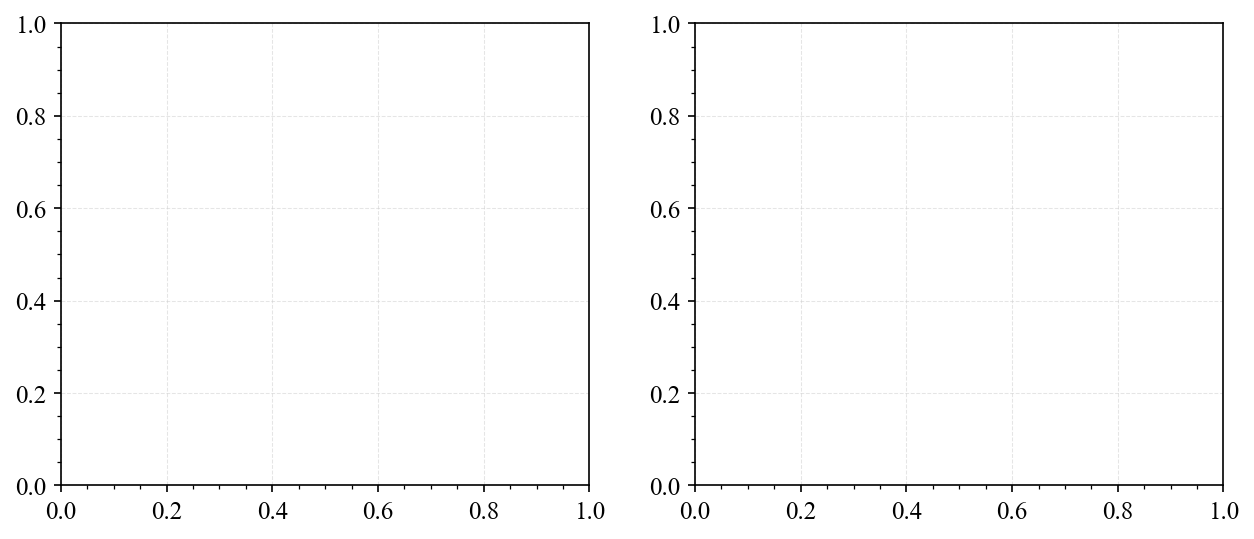

In [10]:
fig, axes = plt.subplots(1,2,figsize=(10,4))
ax = axes.flat[0]
ax.plot(sol_long13["Time [h]"].entries,sol_long13["Positive electrode SOC"].entries,"g")
ax.plot(sol_long23["Time [h]"].entries,sol_long23["Positive electrode SOC"].entries,"r")

ax.set_title("Positive electrode stochiometry")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Time (h)")
ax.set_ylabel("y")
ax = axes.flat[1]
ax.plot(sol_long13["Time [h]"].entries,sol_long13["Negative electrode SOC"].entries,"g")
ax.plot(sol_long23["Time [h]"].entries,sol_long23["Negative electrode SOC"].entries,"r")

ax.set_title("Negative electrode stochiometry")
# ax.set_ylim([2.9,4.5])
ax.set_xlabel("Time (h)")
ax.set_ylabel("x")

In [ ]:
sol_long13.summary_variables.search("electrode")

In [ ]:
sim_long13.plot(
    [
#         "Negative particle surface concentration [mol.m-3]",
#         "Electrolyte concentration [mol.m-3]",
        "Positive particle surface concentration [mol.m-3]",
        "Current [A]",
#         "Negative electrode potential [V]",
#         "Electrolyte potential [V]",
#         "Positive electrode potential [V]",
        "Terminal voltage [V]",
#         "X-averaged cell temperature",
        "Negative electrode SOC",
        "Positive electrode SOC",
        "Total lithium [mol]",
        "Total lithium in electrolyte [mol]",
        "Total lithium in negative electrode [mol]",
        "Total lithium in particles [mol]",
        "Total lithium in positive electrode [mol]",
        "Total lithium lost [mol]",
        "Total lithium lost from electrolyte [mol]",
        "Total lithium lost from particles [mol]",
        "Total lithium lost to side reactions [mol]",
        "Loss of lithium to lithium plating [mol]",
        "Loss of lithium to SEI [mol]",

    ]
)

In [ ]:
# pybamm.plot_summary_variables(sol_long)

In [ ]:
gnffjj

In [10]:
sol_long=sol_long33

x100=sol_long.summary_variables["x_100"]
y100=sol_long.summary_variables["y_100"]
x0=sol_long.summary_variables["x_0"]
y0=sol_long.summary_variables["y_0"]
Cap=sol_long.summary_variables["Capacity [A.h]"]
LoC_SEI_summ=sol_long.summary_variables["Loss of capacity to SEI [A.h]"]
LAM_P=sol_long.summary_variables["Loss of active material in positive electrode [%]"]
LAM_N=sol_long.summary_variables["Loss of active material in negative electrode [%]"]
C_Neg=sol_long.summary_variables["C_n"]
C_pos=sol_long.summary_variables["C_p"]


LLI=sol_long.summary_variables["Loss of lithium inventory [%]"]
LLI_mol= sol_long.summary_variables["Total lithium lost [mol]"]
LLI_Side_mol= sol_long.summary_variables["Total lithium lost to side reactions [mol]"]
LLI_plating_mol= sol_long.summary_variables["Loss of lithium to lithium plating [mol]"]
LLI_SEI_mol= sol_long.summary_variables["Loss of lithium to SEI [mol]"]


cycle_num=sol_long.summary_variables["Cycle number"]
t = sol_long["Time [s]"].entries
I = sol_long["Current [A]"].entries
Q = sol_long['Discharge capacity [A.h]'].entries
LoC_SEI = sol_long["Loss of capacity to SEI [A.h]"].entries
N_SoC = sol_long["Negative electrode SOC"].entries
P_SoC = sol_long["Positive electrode SOC"].entries
Epsilon_n_s_cycled=sol_long["X-averaged negative electrode active material volume fraction"].entries
Epsilon_p_s_cycled=sol_long["X-averaged positive electrode active material volume fraction"].entries
cycle_time=sol_long.summary_variables['Time [s]'],
Vt_t = sol_long["Terminal voltage [V]"].entries,

# LLI_SEI_mol=sol_long["Loss of lithium to SEI [mol]"].entries,
# LLI_plating_mol=sol_long["Loss of lithium to lithium plating [mol]"].entries,









In [11]:
from scipy.io import savemat

ident=""
mdic = {
    "x100"+ident: x100, "y100"+ident:y100, "x0"+ident:x0,"y0"+ident:y0,"Cap"+ident:Cap,
        "LoC_SEI_summ"+ident:LoC_SEI_summ,
        "LAM_P"+ident:LAM_P,"LAM_N"+ident:LAM_N,"C_Neg"+ident:C_Neg,"C_pos"+ident:C_pos,
        "LLI"+ident:LLI,"cycle_num"+ident:cycle_num,
        "t"+ident:t,"LoC_SEI"+ident:LoC_SEI,"N_SoC"+ident:N_SoC,"P_SoC"+ident:P_SoC,
        "Q"+ident:Q, "I"+ident:I,    
#         "ECM_whole_res":ECM_whole_res,"ECM_sum_res":ECM_sum_res,
#         "ECM_sum_res_change":ECM_sum_res_change,"cycle_time":cycle_time 
        "Epsilon_n_s_cycled"+ident:Epsilon_n_s_cycled,
        "Epsilon_p_s_cycled"+ident:Epsilon_p_s_cycled,
        "cycle_time":cycle_time, "Vt_t":Vt_t,
        "LLI_SEI_mol":LLI_SEI_mol,
        "LLI_plating_mol":LLI_plating_mol,
        "LLI_mol":LLI_mol,
        "LLI_Side_mol":LLI_Side_mol
    
       }
savemat("GMJuly__experiment33_July10_half_NMC_diff.mat",mdic)

In [ ]:
spm.variables.search("Lithium")